# Event Selection

In [1]:
# Import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from ast import literal_eval

from collections import defaultdict

In [2]:
def get_hashtag_counts(json):
    
    # Create empty dict where values are stored
    hashtag_count = defaultdict(int)
    
    # Iterate over all tweets, retrieve their hashtags and increment the counter by one
    for tweet in json["data"]:
        try:
            hashtags = tweet["entities"]["hashtags"]
            for hashtag in hashtags:
                hashtag_count[hashtag["tag"]] +=1
        except KeyError:
            continue
            
    return hashtag_count

def get_annotation_counts(json):
    
    annotation_count = defaultdict(int)

    for tweet in json["data"]:
        try:
            annotations = tweet["entities"]["annotations"]
            for annotation in annotations:
                annotation_count[annotation["normalized_text"]] +=1
        except KeyError:
            continue
            
    return annotation_count

In [3]:
def get_entity_count(series):
    dict_count = defaultdict(int)
    
    for entities in series:
        for entity in entities:
            if len(entity) > 0:
                dict_count[entity] += 1
            
    return dict_count

In [4]:
def get_entity_count_by_interval(df,interval,entity_type):
    entity_df = pd.DataFrame()
    
    if interval == "week":
        col_name = "year_calendar_week"
    elif interval == "month":
        col_name = "year_month"
    elif interval == "day":
        col_name = "date"
        
    entity_type = entity_type.lower()
        
    df_sorted = df.sort_values(["created_at"])
    periods = list(df_sorted[col_name].drop_duplicates())
    
    for period in periods:
        df_sliced = df[df[col_name] == period]
        entity_count = get_entity_count(df_sliced[entity_type])
        entity_count_sorted = sorted(entity_count.items(), key=lambda x: x[1], reverse=True)
        
        entity_df[period] = pd.DataFrame(entity_count_sorted[:15]).iloc[:,0]
        
    return entity_df

In [5]:
def group_df(df,interval):
    
    if interval == "week":
        col_name = "year_calendar_week"
    elif interval == "month":
        col_name = "year_month"
    elif interval == "day":
        col_name = "date"
    
    
    df_grouped = df.groupby([col_name])[['refugee', 'migrant', 'immigrant', 'asylum_seeker', 'other']].sum()
    df_grouped["total"] = df_grouped.sum(axis=1)
    
    return df_grouped

In [6]:
def plot_event_timeline(df, interval):
    
    df_grouped = group_df(df,interval)
    
    plt.figure(figsize=(16, 8))
    plt.plot(df_grouped["total"])
    #plt.title(f"Number of tweets about refugees and related groups by {interval}")
    plt.xticks(rotation=90)
    plt.show()
    
    plt.figure(figsize=(16, 8))
    plt.plot(df_grouped["refugee"], label ="refugee")
    plt.plot(df_grouped["migrant"], label ="migrant")
    plt.plot(df_grouped["immigrant"], label ="immigrant")
    plt.plot(df_grouped["asylum_seeker"], label ="asylum seeker")
    plt.plot(df_grouped["other"], label ="other")
    #plt.title(f"Grouped number of tweets about refugees and related groups by {interval}")
    plt.xticks(rotation=90)
    plt.legend()
    plt.show()

In [7]:
def plot_entity_timeline(df, interval, entity_list, entity_type):
    
    plt.figure(figsize=(16, 8))
    
    if interval == "week":
        col_name = "year_calendar_week"
    elif interval == "month":
        col_name = "year_month"    
    
    #df_to_plot = pd.DataFrame()
    df_to_plot = pd.DataFrame(index=df[col_name].drop_duplicates().values)
    
    for entity in entity_list:
        df_entity = df[df[entity_type].apply(lambda x: element_in_list(x,[entity]))]
        df_grouped = group_df(df_entity,interval)["total"]
        df_to_plot[entity] = df_grouped
    
    plt.plot(df_to_plot)
    
    plt.xticks(rotation=90)
    plt.legend(df_to_plot.columns)
    plt.show()

In [8]:
def filter_by_keywords(string, keywords):
    keywords_joined = " ".join(keywords)
    return any(word in string for word in keywords_joined)

In [9]:
def hashtag_check(df,entity_list,entity_type):
    plot_entity_timeline(df,"week",entity_list,entity_type)
    
    for entity in entity_list:
        df_entity = df[df[entity_type].apply(lambda x: element_in_list(x,[entity]))]

        hashtag_count = get_entity_count(df_entity[entity_type])
        hashtag_count_sorted = sorted(hashtag_count.items(), key=lambda x: x[1], reverse=True)

        for hashtag,count in hashtag_count_sorted[:15]:
            print(hashtag,count)
        print("\n------------------------------------------\n")


In [10]:
def element_in_list(entities,qualifiers):

    return not(bool(set(entities).isdisjoint(set(qualifiers))))

# !

In [11]:
FILE_PATH = r"C:\Users\jawo19ad\Dropbox (CBS)\Master thesis data"

# !

In [3]:
# Read the tweets csv
df_tweets = pd.read_csv(r"C:\Users\jawo19ad\Dropbox (CBS)\Master thesis data\df_tweets.csv",
                        converters={"hashtags": lambda x: x.strip("[]").replace("'","").split(", "),
                                    "mentions": lambda x: x.strip("[]").replace("'","").split(", "),
                                    "annotations": lambda x: x.strip("[]").replace("'","").split(", ")})

# Drop unnecessary index column
df_tweets.drop("Unnamed: 0", axis=1, inplace=True)

# Rename columns
#df_tweets = df_tweets.rename(columns={'public_metrics.retweet_count': 'retweet_count',
#                                      'public_metrics.reply_count': 'reply_count',
#                                      'public_metrics.like_count': 'like_count',
#                                      'public_metrics.quote_count': 'quote_count'})
df_tweets.head()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3147: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


source                                               text  \
0  Twitter for Android  There are too many reliable reports and first-...   
1      Twitter Web App  Despite repeated requests, @Refugees and other...   
2  Twitter for Android  ‚ÄúWhen the air bombing and the attacks began, I...   
3      Twitter Web App  "ongoing insecurity &amp; allegations of grave...   
4   Twitter for iPhone  MOTHER \n\nMother, I do not cry who cries, \nm...   

  lang                   id                created_at            author_id  \
0   en  1350390669043499013  2021-01-16T10:33:19.000Z  1327278886380515328   
1   en  1350390657576300544  2021-01-16T10:33:16.000Z  1323903491044188161   
2   en  1350390643986599937  2021-01-16T10:33:13.000Z  1324130252008816640   
3   en  1350390618695020546  2021-01-16T10:33:07.000Z           1112761003   
4   en  1350390607928295424  2021-01-16T10:33:04.000Z  1212824799107375105   

   retweet_count  reply_count  like_count  quote_count withheld.scope  \
0              1            0           0            0            NaN   
1              0            0           0            0            NaN   
2              0            0           1            0            NaN   
3              0            0           0            0            NaN   
4              0            1           0            0            NaN   

                                            hashtags  \
0  [eritrea, bidentakeaction, stopwarontigray, ti...   
1  [tigray, stopwarontigray, tigraygenocide, bide...   
2                                  [bidentakeaction]   
3     [tigraygenocide, bidenactnow, protectrefugees]   
4                                                 []   

                                            mentions          annotations  
0                                         [joebiden]                   []  
1                           [refugees, un, joebiden]  [shimelba, hitsats]  
2          [joebiden, kamalaharris, yohannesabraham]                   []  
3  [un, joebiden, eu_commission, refugees, josepb...            [eritrea]  
4                                                 []                   []

In [4]:
min(df_tweets["created_at"])

'2020-01-01T00:00:00.000Z'

In [5]:
df_tweets.shape

(12758376, 14)

In [209]:
df_tweets["text_clean"] = df_tweets["text"].apply(lambda x: x.lower().replace("#","").replace("@",""))

In [210]:
df_tweets = df_tweets.sort_values(by="created_at")

In [211]:
df_tweets.head()

source  \
11850722  Twitter Media Studio   
11850721    Twitter for iPhone   
11850720        SocialNewsDesk   
11850719        SocialNewsDesk   
11850718               dlvr.it   

                                                       text lang  \
11850722  ‚ÄúI decided to go to Europe because I have a dr...   en   
11850721  @BevanShields @mickgleeson You know how Al-Qae...   en   
11850720  The outcry over medical care began when two ch...   en   
11850719  Border Report examined the challenges faced by...   en   
11850718  Migrant with gunshot wound evacuated from Open...   en   

                           id                created_at            author_id  \
11850722  1212161513517125633  2020-01-01T00:00:00.000Z              4970411   
11850721  1212161513990979584  2020-01-01T00:00:00.000Z            528911765   
11850720  1212161519636623362  2020-01-01T00:00:01.000Z             52099553   
11850719  1212161524858576897  2020-01-01T00:00:03.000Z  1146450366730592257   
11850718  1212161534740164608  2020-01-01T00:00:05.000Z             14549486   

          retweet_count  reply_count  like_count  quote_count withheld.scope  \
11850722             29           15          92            4            NaN   
11850721              0            0           1            0            NaN   
11850720              0            0           2            0            NaN   
11850719              1            0           1            0            NaN   
11850718              0            0           0            0            NaN   

                      hashtags                     mentions  \
11850722                    []                           []   
11850721  [scottyfommarketing]  [bevanshields, mickgleeson]   
11850720                    []                           []   
11850719                    []                           []   
11850718                    []                           []   

                                                annotations  \
11850722  [europe, al jazeera, ocean viking, mediterranean]   
11850721                                         [al-qaeda]   
11850720                                    [border patrol]   
11850719                                                 []   
11850718                                                 []   

                                                 text_clean  
11850722  ‚Äúi decided to go to europe because i have a dr...  
11850721  bevanshields mickgleeson you know how al-qaeda...  
11850720  the outcry over medical care began when two ch...  
11850719  border report examined the challenges faced by...  
11850718  migrant with gunshot wound evacuated from open...

### Most frequent hashtags, mentions, and annotations

In [212]:
hashtag_count = get_entity_count(df_tweets["hashtags"])
hashtag_count_sorted = sorted(hashtag_count.items(), key=lambda x: x[1], reverse=True)
hashtag_count_sorted[:25]

[('refugees', 133222),
 ('covid19', 129252),
 ('whatshappeninginmyanmar', 114189),
 ('tigraygenocide', 109762),
 ('migrants', 75212),
 ('tigray', 72746),
 ('dv2021', 66304),
 ('immigrants', 55933),
 ('s386', 46088),
 ('coronavirus', 45811),
 ('immigration', 44687),
 ('refugee', 42287),
 ('stopwarontigray', 34166),
 ('ethiopia', 34130),
 ('standwithiraqirefugees', 32213),
 ('rohingya', 28077),
 ('greece', 27064),
 ('iraqi_refugees_look_for_homeland', 27028),
 ('dv2020', 24964),
 ('refugeeswelcome', 24086),
 ('turkey', 23014),
 ('immigrant', 22602),
 ('syria', 22400),
 ('noban', 21876),
 ('migrant', 21827)]

In [213]:
mention_count = get_entity_count(df_tweets["mentions"])
mention_count_sorted = sorted(mention_count.items(), key=lambda x: x[1], reverse=True)
mention_count_sorted[:25]

[('realdonaldtrump', 234995),
 ('refugees', 215749),
 ('potus', 143824),
 ('joebiden', 131396),
 ('un', 112492),
 ('pritipatel', 104767),
 ('nigel_farage', 79185),
 ('narendramodi', 64745),
 ('borisjohnson', 60280),
 ('vp', 56573),
 ('hrw', 55117),
 ('secblinken', 55114),
 ('change', 50223),
 ('cnn', 47903),
 ('aoc', 47832),
 ('youtube', 45929),
 ('kamalaharris', 44918),
 ('eu_commission', 44121),
 ('pmoindia', 42983),
 ('unhumanrights', 42624),
 ('senatordurbin', 41017),
 ('amnesty', 39227),
 ('breitbartnews', 38927),
 ('statedept', 35018),
 ('ilhanmn', 34737)]

In [214]:
annotation_count = get_entity_count(df_tweets["annotations"])
annotation_count_sorted = sorted(annotation_count.items(), key=lambda x: x[1], reverse=True)
annotation_count_sorted[:25]

[('trump', 675992),
 ('us', 428297),
 ('biden', 358099),
 ('america', 336594),
 ('uk', 327496),
 ('india', 209271),
 ('turkey', 208180),
 ('europe', 180654),
 ('u.s.', 170179),
 ('canada', 152093),
 ('americans', 131957),
 ('mexico', 131329),
 ('france', 127652),
 ('usa', 120318),
 ('greece', 113298),
 ('eu', 101027),
 ('obama', 99330),
 ('china', 98590),
 ('texas', 90594),
 ('democrats', 89481),
 ('germany', 86492),
 ('syria', 82045),
 ('god', 73923),
 ('myanmar', 72688),
 ('united states', 71787)]

### Add additional date columns (Year, Month, Calendar Week, etc)

In [215]:
df_tweets["created_at"] = pd.to_datetime(df_tweets["created_at"])

In [217]:
df_tweets["year"] = df_tweets["created_at"].dt.year.astype(str)
df_tweets["calendar_week"] = df_tweets["created_at"].apply(lambda x: x.strftime("%W")) #Monday considered as first day of the week
df_tweets["year_month"] = df_tweets["year"] + "_" + df_tweets["created_at"].dt.month.astype(str)
df_tweets["year_calendar_week"] = df_tweets["year"] + "_" + df_tweets["calendar_week"]
df_tweets["date"] = df_tweets["created_at"].dt.date.astype(str)

In [219]:
df_tweets["refugee"] = df_tweets["text_clean"].apply(lambda x: element_in_list(x.split(" "),["refugee","refugees"]))
df_tweets["migrant"] = df_tweets["text_clean"].apply(lambda x: element_in_list(x.split(" "),["migrant","migrants"]))
df_tweets["immigrant"] = df_tweets["text_clean"].apply(lambda x: element_in_list(x.split(" "),["immigrant","immigrants"]))
df_tweets["asylum_seeker"] = df_tweets["text_clean"].apply(lambda x: element_in_list(x.split(" "),["asylum"]) and  element_in_list(x.split(" "),["seeker","seekers"]))
df_tweets["other"] = df_tweets["text_clean"].apply(lambda x: element_in_list(x.split(" "),["displaced","stateless"]) and  element_in_list(x.split(" "),["people","person","persons"]))

In [220]:
df_tweets[["refugee","migrant","immigrant","asylum_seeker","other"]].sum(axis=0)

refugee          2592276
migrant          2677782
immigrant        3884464
asylum_seeker     361934
other             156666
dtype: int64

In [221]:
check = df_tweets[(df_tweets["refugee"] == False) & (df_tweets["migrant"] == False) & (df_tweets["immigrant"] == False) & (df_tweets["asylum_seeker"] == False) & (df_tweets["other"] == False)]
check.shape
# there are still about 3 million tweets that contain neither of the keywords, this is because the keywords are heading the article to which those tweets link

(3332215, 25)

In [222]:
sum(df_tweets["refugee"]) + sum(df_tweets["migrant"]) + sum(df_tweets["immigrant"]) + sum(df_tweets["asylum_seeker"]) + sum(df_tweets["other"])

9673122

In [223]:
df_tweets.head()

source  \
11850722  Twitter Media Studio   
11850721    Twitter for iPhone   
11850720        SocialNewsDesk   
11850719        SocialNewsDesk   
11850718               dlvr.it   

                                                       text lang  \
11850722  ‚ÄúI decided to go to Europe because I have a dr...   en   
11850721  @BevanShields @mickgleeson You know how Al-Qae...   en   
11850720  The outcry over medical care began when two ch...   en   
11850719  Border Report examined the challenges faced by...   en   
11850718  Migrant with gunshot wound evacuated from Open...   en   

                           id                created_at            author_id  \
11850722  1212161513517125633 2020-01-01 00:00:00+00:00              4970411   
11850721  1212161513990979584 2020-01-01 00:00:00+00:00            528911765   
11850720  1212161519636623362 2020-01-01 00:00:01+00:00             52099553   
11850719  1212161524858576897 2020-01-01 00:00:03+00:00  1146450366730592257   
11850718  1212161534740164608 2020-01-01 00:00:05+00:00             14549486   

          retweet_count  reply_count  like_count  quote_count  ...  year  \
11850722             29           15          92            4  ...  2020   
11850721              0            0           1            0  ...  2020   
11850720              0            0           2            0  ...  2020   
11850719              1            0           1            0  ...  2020   
11850718              0            0           0            0  ...  2020   

         calendar_week year_month year_calendar_week        date refugee  \
11850722            00     2020_1            2020_00  2020-01-01   False   
11850721            00     2020_1            2020_00  2020-01-01    True   
11850720            00     2020_1            2020_00  2020-01-01   False   
11850719            00     2020_1            2020_00  2020-01-01   False   
11850718            00     2020_1            2020_00  2020-01-01   False   

         migrant immigrant asylum_seeker  other  
11850722    True     False         False  False  
11850721   False     False         False  False  
11850720   False     False         False  False  
11850719   False     False          True  False  
11850718    True     False         False  False  

[5 rows x 25 columns]

In [224]:
df_tweets.to_csv(r"C:\Users\jawo19ad\Dropbox (CBS)\Master thesis data\df_tweets_event_selection.csv")

---

## Identification of Events

In [12]:
# Read the tweets csv
df_tweets = pd.read_csv(r"C:\Users\jawo19ad\Dropbox (CBS)\Master thesis data\df_tweets_event_selection.csv",
                        converters={"hashtags": lambda x: x.strip("[]").replace("'","").split(", "),
                                    "mentions": lambda x: x.strip("[]").replace("'","").split(", "),
                                    "annotations": lambda x: x.strip("[]").replace("'","").split(", ")})

# Drop unnecessary index column
df_tweets.drop("Unnamed: 0", axis=1, inplace=True)

# Rename columns
#df_tweets = df_tweets.rename(columns={'public_metrics.retweet_count': 'retweet_count',
#                                      'public_metrics.reply_count': 'reply_count',
#                                      'public_metrics.like_count': 'like_count',
#                                      'public_metrics.quote_count': 'quote_count'})
df_tweets.head()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3147: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


source                                               text  \
0  Twitter Media Studio  ‚ÄúI decided to go to Europe because I have a dr...   
1    Twitter for iPhone  @BevanShields @mickgleeson You know how Al-Qae...   
2        SocialNewsDesk  The outcry over medical care began when two ch...   
3        SocialNewsDesk  Border Report examined the challenges faced by...   
4               dlvr.it  Migrant with gunshot wound evacuated from Open...   

  lang                   id                 created_at            author_id  \
0   en  1212161513517125633  2020-01-01 00:00:00+00:00              4970411   
1   en  1212161513990979584  2020-01-01 00:00:00+00:00            528911765   
2   en  1212161519636623362  2020-01-01 00:00:01+00:00             52099553   
3   en  1212161524858576897  2020-01-01 00:00:03+00:00  1146450366730592257   
4   en  1212161534740164608  2020-01-01 00:00:05+00:00             14549486   

   retweet_count  reply_count  like_count  quote_count  ...  year  \
0             29           15          92            4  ...  2020   
1              0            0           1            0  ...  2020   
2              0            0           2            0  ...  2020   
3              1            0           1            0  ...  2020   
4              0            0           0            0  ...  2020   

  calendar_week year_month year_calendar_week        date  refugee  migrant  \
0             0     2020_1            2020_00  2020-01-01    False     True   
1             0     2020_1            2020_00  2020-01-01     True    False   
2             0     2020_1            2020_00  2020-01-01    False    False   
3             0     2020_1            2020_00  2020-01-01    False    False   
4             0     2020_1            2020_00  2020-01-01    False     True   

  immigrant asylum_seeker  other  
0     False         False  False  
1     False         False  False  
2     False         False  False  
3     False          True  False  
4     False         False  False  

[5 rows x 25 columns]

### Frequency of Tweets over Time (also seperated by refugee/migrant/etc.)

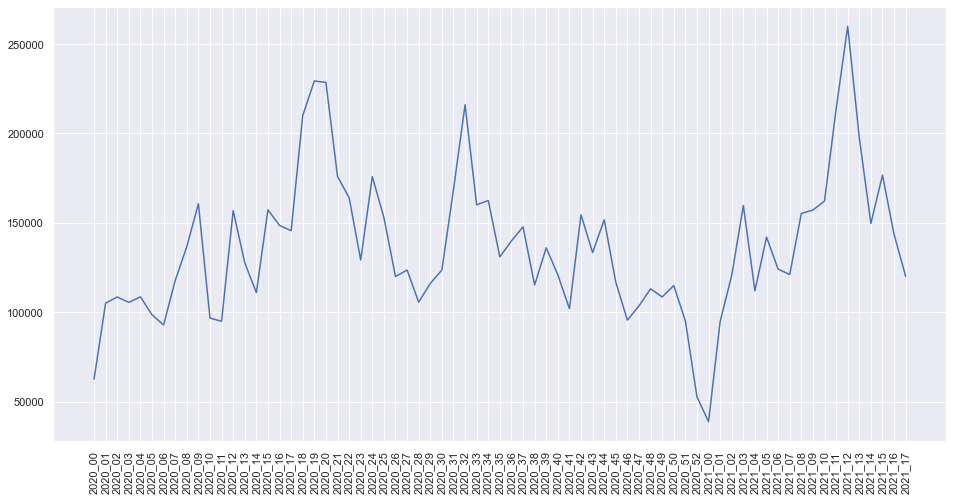

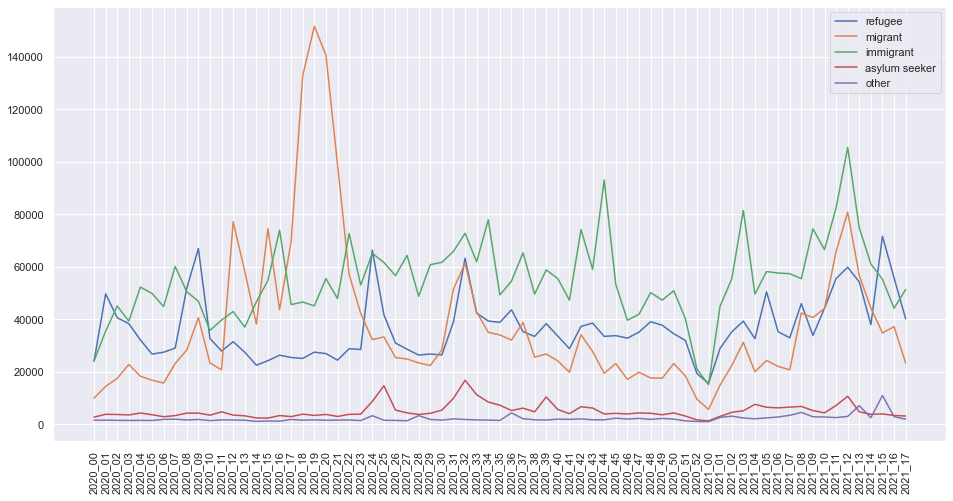

In [13]:
plot_event_timeline(df_tweets,"week")

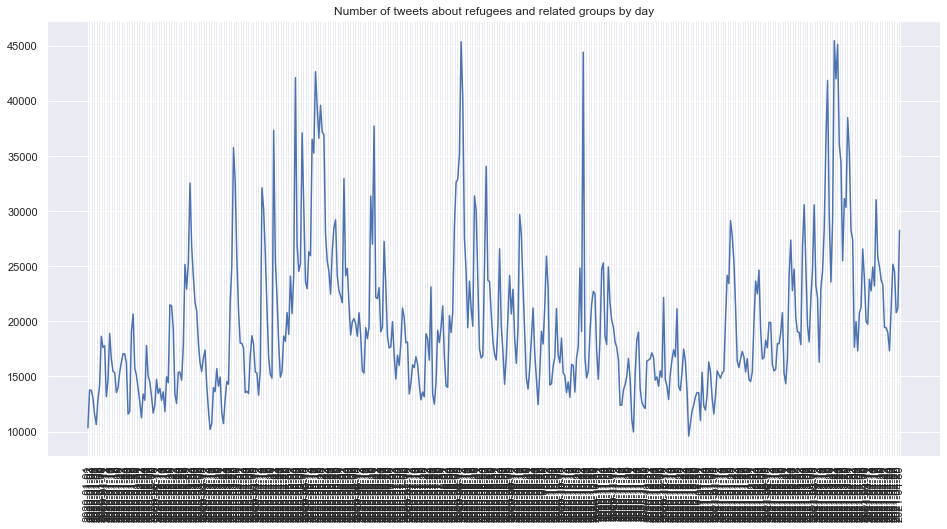

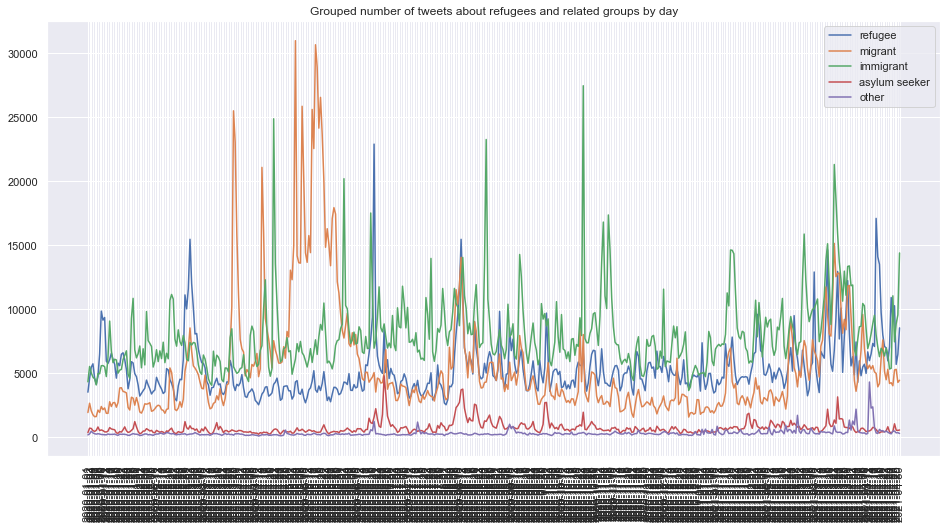

In [226]:
plot_event_timeline(df_tweets,"day")

### Most frequent entities per month

In [13]:
df_hashtags_month = get_entity_count_by_interval(df_tweets[df_tweets["refugee"]],"month","hashtags")
df_mentions_month = get_entity_count_by_interval(df_tweets[df_tweets["refugee"]],"month","mentions")
df_annotations_month = get_entity_count_by_interval(df_tweets[df_tweets["refugee"]],"month","annotations")

### Most frequent entities per week

In [14]:
df_hashtags_week = get_entity_count_by_interval(df_tweets[df_tweets["refugee"]],"week","hashtags")
df_mentions_week = get_entity_count_by_interval(df_tweets[df_tweets["refugee"]],"week","mentions")
df_annotations_week = get_entity_count_by_interval(df_tweets[df_tweets["refugee"]],"week","annotations")

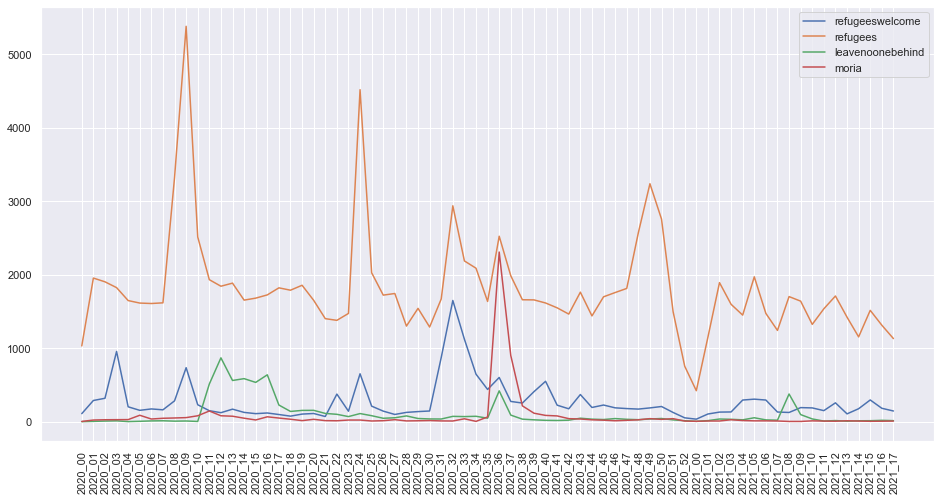

refugeeswelcome 24086
refugees 5424
leavenoonebehind 2001
unhcr 1401
refugee 1321
help 1006
malaysia 1001
community 837
love 806
children 799
scrap37 785
peace 783
safepassage 657
greece 597
withrefugees 581

------------------------------------------

refugees 133222
covid19 9337
migrants 9102
turkey 7541
syria 6791
greece 6063
refugeeswelcome 5398
eu 5102
humanrights 4708
asylumseekers 4608
rohingya 4492
unhcr 4470
tigray 4304
sudan 4285
war 4201

------------------------------------------

leavenoonebehind 9371
covid19 4482
refugeeswelcome 2001
moria 607
refugees 499
worldngoday 324
refugeesgr 184
refugee 125
greece 123
moria2 112
migrants 107
wirhabenplatz 94
eu 90
europemustact 84
karatepe 83

------------------------------------------

moria 6576
greece 1852
refugees 1278
lesbos 968
lesvos 852
leavenoonebehind 605
refugeesgr 497
refugeeswelcome 429
eu 376
migrants 368
fire 357
moriacamp 337
refugee 313
mitsotakis 244
covid19 229

------------------------------------------



In [67]:
hashtag_check(df_tweets,["refugeeswelcome","refugees","leavenoonebehind","moria"],"hashtags")

In [63]:
df_annotations_week["2020_38"]

0           gavin newsom
1                 newsom
2     refugee kao saelee
3                 turkey
4                  trump
5                 europe
6                 greece
7                     us
8                     uk
9                 canada
10                    eu
11             australia
12                 syria
13               america
14                  iraq
Name: 2020_38, dtype: object

---

### Channel Crossing

In [17]:
df_hashtags_week["2020_32"]

0                   refugees
1            refugeeswelcome
2                      unhcr
3                   malaysia
4                    refugee
5                    covid19
6                  community
7     standwithiraqirefugees
8                       help
9                      peace
10               safepassage
11                  migrants
12                  children
13                      love
14                   lebanon
Name: 2020_32, dtype: object

In [21]:
df_annotations_week["2020_32"]

0          uk
1      france
2      turkey
3      europe
4      greece
5       syria
6          eu
7     britain
8     germany
9          us
10    lebanon
11       iraq
12     canada
13        bbc
14     farage
Name: 2020_32, dtype: object

In [22]:
df_mentions_week["2020_32"]

0         pritipatel
1       nigel_farage
2           refugees
3     benandjerrysuk
4            skynews
5        garylineker
6            bbcnews
7       borisjohnson
8       jeremycorbyn
9     simonjonesnews
10      bbcbreakfast
11         ayocaesar
12      ukhomeoffice
13                un
14         mrjamesob
Name: 2020_32, dtype: object

In [90]:
df_tweets_channel = df_tweets[(df_tweets["created_at"] < "2020-08-30") & (df_tweets["created_at"] > "2020-07-19")]

In [91]:
df_tweets_channel.shape

(1249636, 25)

In [92]:
channel_hashtags_1 = ["uk","france","britain"]

In [93]:
df_tweets_channel_1 = df_tweets_channel[df_tweets_channel["hashtags"].apply(lambda x: element_in_list(x,channel_hashtags_1))]
df_tweets_channel_1.shape

(2510, 25)

In [94]:
hashtag_count = get_entity_count(df_tweets_channel_1["hashtags"])

# Remove hashtags that are already in list
for hashtag in channel_hashtags_1:
    hashtag_count.pop(hashtag)

# Sort hashtags by frequency
hashtag_count_sorted = sorted(hashtag_count.items(), key=lambda x: x[1], reverse=True)
hashtag_count_sorted[:25]

[('migrants', 472),
 ('refugees', 293),
 ('brexit', 239),
 ('eu', 213),
 ('british', 131),
 ('immigration', 120),
 ('news', 90),
 ('immigrants', 90),
 ('pritipatel', 85),
 ('channel', 83),
 ('migrant', 76),
 ('dover', 75),
 ('migration', 72),
 ('asylum', 71),
 ('syria', 65),
 ('politics', 62),
 ('europe', 61),
 ('englishchannel', 60),
 ('borisjohnson', 59),
 ('turkey', 56),
 ('asylumseekers', 56),
 ('covid19', 53),
 ('germany', 50),
 ('usa', 49),
 ('muslim', 49)]

In [95]:
channel_hashtags_2 = channel_hashtags_1 + ["brexit","eu","british","pritipatel","channel","dover",
                                           "europe","englishchannel","borisjohnson"]

In [96]:
seen_hashtags = set([hashtag for hashtag,count in hashtag_count_sorted[:25]] + channel_hashtags_2)

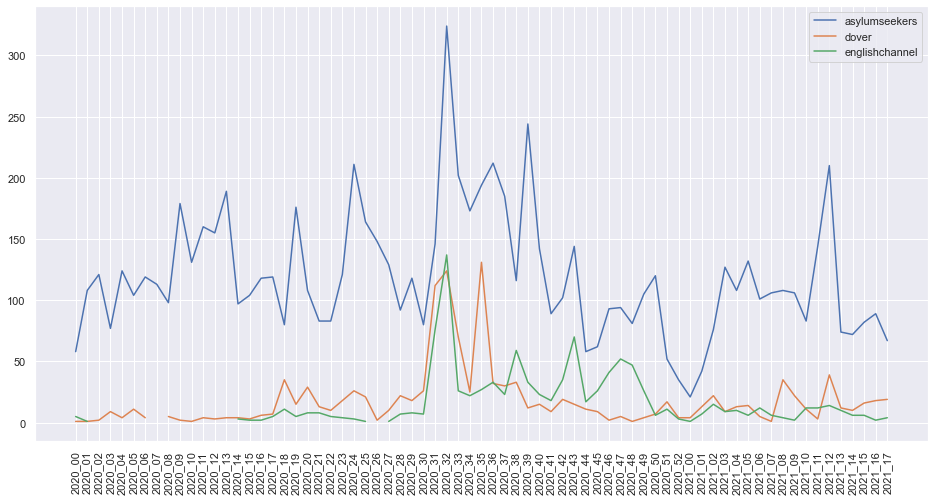

asylumseekers 9706
refugees 4619
migrants 1612
immigration 761
covid19 705
asylum 691
humanrights 665
immigrants 665
migration 521
auspol 490
refugeeswelcome 415
greece 400
refugee 358
children 264
coronavirus 263

------------------------------------------

dover 1435
migrants 421
calais 144
uk 137
kent 104
illegalimmigrants 102
borderforce 99
englishchannel 83
immigrants 75
refugees 71
france 58
politicalislam 58
asylumseekers 58
pritipatel 57
invasion 57

------------------------------------------

englishchannel 857
refugees 355
migrants 301
immigrants 294
borders 275
mediterranean 272
illegal 271
turkey 270
legal 269
standwithiraqirefugees 269
iraqi_refugees_look_for_homeland 262
uk 110
illegalimmigrants 91
dover 83
calais 79

------------------------------------------



In [31]:
hashtag_check(df_tweets,["asylumseekers","dover","englishchannel"],"hashtags")

In [97]:
df_tweets_channel_2 = df_tweets_channel[df_tweets_channel["hashtags"].apply(lambda x: element_in_list(x,channel_hashtags_2))]
df_tweets_channel_2.shape

(6878, 25)

In [98]:
hashtag_count = get_entity_count(df_tweets_channel_2["hashtags"])

# Remove hashtags that are already in list
for hashtag in seen_hashtags:
    hashtag_count.pop(hashtag)

# Sort hashtags by frequency
hashtag_count_sorted = sorted(hashtag_count.items(), key=lambda x: x[1], reverse=True)
hashtag_count_sorted[:25]

[('greece', 177),
 ('refugeeswelcome', 157),
 ('refugee', 130),
 ('illegalimmigrants', 114),
 ('libya', 112),
 ('calais', 106),
 ('migrantcrisis', 101),
 ('brexitreality', 90),
 ('italy', 86),
 ('humanrights', 85),
 ('coronavirus', 82),
 ('farage', 82),
 ('travel', 79),
 ('nigelfarage', 79),
 ('skynews', 76),
 ('illegal', 75),
 ('weather', 71),
 ('severewx', 71),
 ('euwx', 71),
 ('wx', 71),
 ('french', 69),
 ('bbcnews', 69),
 ('erdogan', 62),
 ('un', 61),
 ('labour', 61)]

In [99]:
channel_hashtags_3 = channel_hashtags_2 + ["calais","brexitreality","farage","nigelfarage","french","bbcnews"]

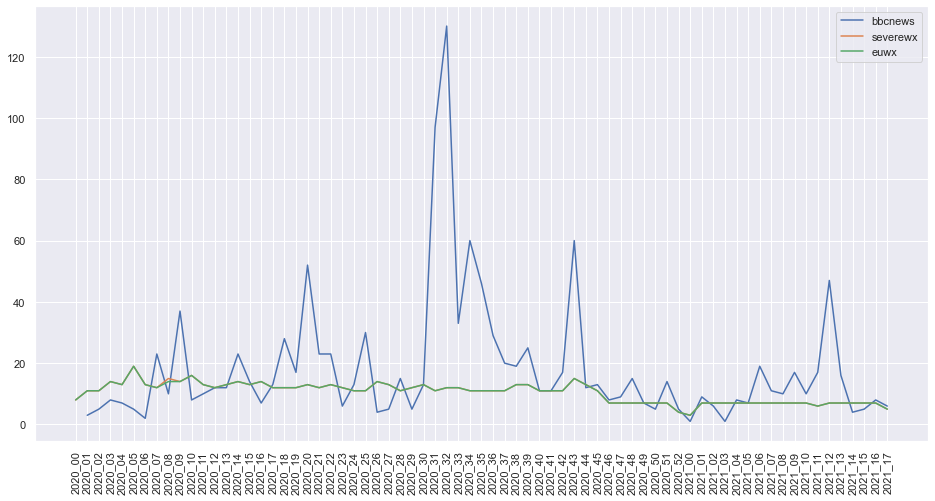

bbcnews 1533
skynews 593
c4news 348
itvnews 311
lbc 215
newsnight 184
migrants 163
bbcbreakfast 135
talkradio 106
bbcpm 79
r4today 75
france 75
wato 74
covid19 74
eu 64

------------------------------------------

severewx 730
wx 730
news 730
weather 729
europe 729
refugees 729
travel 729
euwx 729
roughsleepers 8
migrants 8
stormgloria 1
gloria 1
indonesiafloods 1
nbdm 1
jakarta 1

------------------------------------------

weather 729
europe 729
refugees 729
travel 729
severewx 729
euwx 729
wx 729
news 729
roughsleepers 8
migrants 8
stormgloria 1
gloria 1

------------------------------------------



In [44]:
hashtag_check(df_tweets,["bbcnews","severewx","euwx"],"hashtags")

In [100]:
df_tweets_channel_3 = df_tweets_channel[df_tweets_channel["hashtags"].apply(lambda x: element_in_list(x,channel_hashtags_3))]
df_tweets_channel_3.shape

(7885, 25)

In [101]:
channel_hashtag_qualifier = channel_hashtags_3

#### Create event qualifier

In [102]:
annotation_count = get_entity_count(df_tweets_channel_3["annotations"])

# Sort hashtags by frequency
annotation_count_sorted = sorted(annotation_count.items(), key=lambda x: x[1], reverse=True)
annotation_count_sorted[:25]

[('uk', 1407),
 ('france', 717),
 ('eu', 354),
 ('britain', 278),
 ('europe', 211),
 ('brexit', 137),
 ('priti patel', 118),
 ('u.k.', 82),
 ('dover', 80),
 ('calais', 79),
 ('greece', 78),
 ('farage', 76),
 ('germany', 73),
 ('libya', 66),
 ('dublin', 65),
 ('nigel farage', 62),
 ('england', 58),
 ('ben', 55),
 ('boris johnson', 53),
 ('jerry', 53),
 ('italy', 51),
 ('bbc', 50),
 ('turkey', 48),
 ('kent', 46),
 ('islamising europe', 44)]

In [103]:
channel_annotation_qualifier = ["uk","france","eu","britain","europe","brexit","patel","dover","u.k.","farage","calais","england",
                                "bbc","kent"]

In [78]:
mention_count = get_entity_count(df_tweets_channel_3["mentions"])

# Sort hashtags by frequency
mention_count_sorted = sorted(mention_count.items(), key=lambda x: x[1], reverse=True)
mention_count_sorted[:25]

[('pritipatel', 585),
 ('borisjohnson', 368),
 ('nigel_farage', 340),
 ('bbcnews', 153),
 ('skynews', 122),
 ('ukhomeoffice', 92),
 ('conservatives', 91),
 ('refugees', 65),
 ('lbc', 63),
 ('gmb', 47),
 ('youtube', 44),
 ('eu_commission', 42),
 ('dominicraab', 42),
 ('bbcbreakfast', 42),
 ('jacindaardern', 40),
 ('emmanuelmacron', 39),
 ('10downingstreet', 39),
 ('iromg', 37),
 ('mailonline', 36),
 ('guardian', 35),
 ('benandjerrysuk', 34),
 ('fcotravel', 33),
 ('realdonaldtrump', 32),
 ('talkradio', 31),
 ('benandjerrys', 30)]

In [79]:
channel_mention_qualifier = []

#### Create event dataset

In [104]:
channel_qualifier = set(channel_hashtag_qualifier + channel_annotation_qualifier)

In [105]:
df_tweets_channel_final = df_tweets_channel[df_tweets_channel["text_clean"].apply(lambda x: element_in_list(x.split(" "),channel_qualifier))]
df_tweets_channel_final = df_tweets_channel_final.append(df_tweets_channel_3).drop_duplicates(subset=["id"])

In [106]:
df_tweets_channel_final.shape

(196116, 25)

#### Visualize event

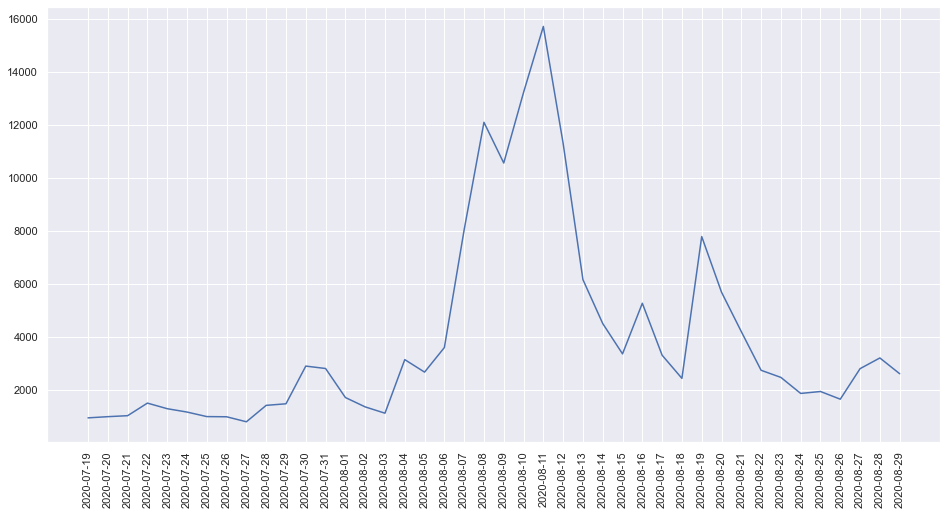

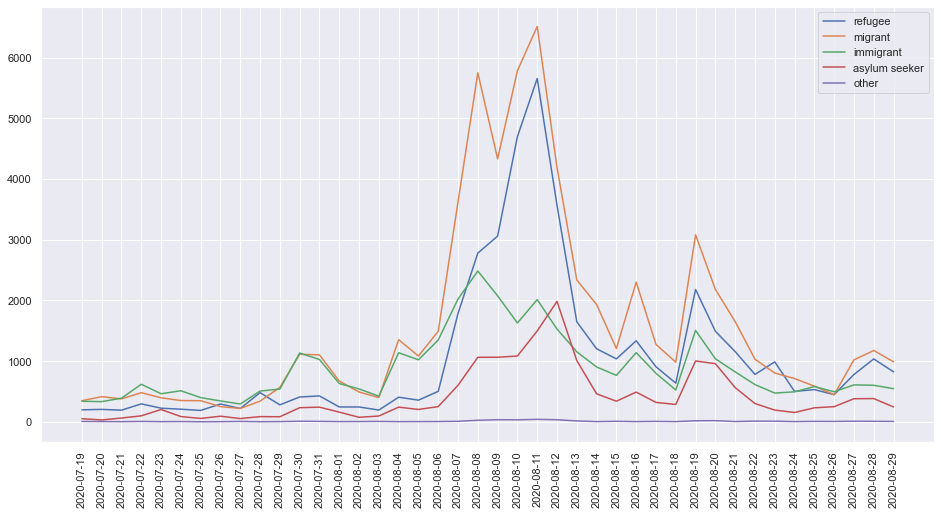

In [83]:
plot_event_timeline(df_tweets_channel_final,"day")

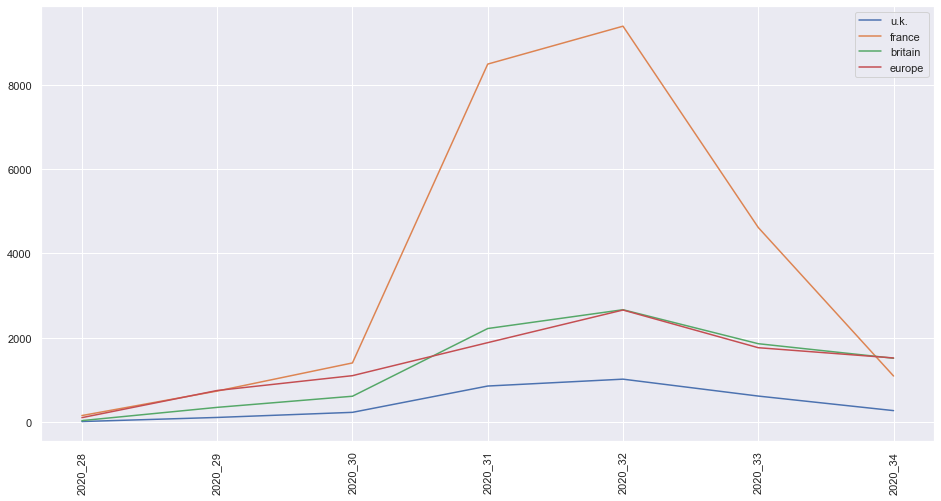

In [85]:
plot_entity_timeline(df_tweets_channel_final, "week", ["u.k.","france","britain","europe"], "annotations")

In [86]:
df_tweets_channel_final.iloc[84020,1]

'French warn Royal Navy to stay out of their waters while Boris Johnson calls for new powers to kick out illegal migrants https://t.co/cqTezqfwvg'

In [87]:
df_tweets_channel_final.shape

(196116, 25)

In [107]:
for text in df_tweets_channel_final.sample(100)["text"]:
    print(text)
    print("----------------")

SHOCKING: Britain First visits migrant hotel near Birmingham! https://t.co/BKdQqYdpll
----------------
@pritipatel you promised tough action months ago yet yesterday we had over 200 illegal immigrants enter our shores a new record ! You are weak and embarrassing and are not fit for office or to represent this nation !
----------------
@LokiSkywalker Priti is the best ever  immigrant of Britain, she is our hajarama of Britain
----------------
Politics latest news: Migrant crisis reveals 'hollowness' of Brexit rhetoric, former National Security Adviser says

https://t.co/fjsJM150GT
----------------
The true story is that Nigel Farage is being a racist
https://t.co/nzprJS8YF1
----------------
‚ÄòNational Humiliation‚Äô: 1,000 Illegal Boat Migrants Reach UK in 10 Straight Days of Channel Crossings https://t.co/qIsjZJlxd0
----------------
@pritipatel After the 2nd World War, some displaced Jewish refugees made it to Pakestine in hope of a better life.  These people are described by the mode

#### Export the dataset as csv

In [108]:
channel_path = FILE_PATH + "\Event Dataframes\df_channel.csv"

In [109]:
df_tweets_channel_final.to_csv(channel_path)

---

### Border Greece/Turkey + Idlib (9/2020)

In [51]:
df_hashtags_week["2020_09"]

0                   refugees
1                     greece
2                     turkey
3     standwithiraqirefugees
4                      syria
5                    refugee
6                         eu
7           istandwithgreece
8                     europe
9          greeceunderattack
10                     idlib
11                     greek
12       greece_under_attack
13           refugeeswelcome
14                   erdogan
Name: 2020_09, dtype: object

In [14]:
df_tweets_greece = df_tweets[(df_tweets["created_at"] < "2020-03-24") & (df_tweets["created_at"] > "2020-02-11")]

In [16]:
df_tweets_greece.shape

(926058, 25)

In [17]:
greece_hashtags_1 = ["greece","turkey","syria","eu","istandwithgreece","europe","greeceunderattack","idlib","greek","greece_under_attack","erdogan"]

In [18]:
df_tweets_greece_1 = df_tweets_greece[df_tweets_greece["hashtags"].apply(lambda x: element_in_list(x,greece_hashtags_1))]
df_tweets_greece_1.shape

(33053, 25)

In [407]:
hashtag_count = get_entity_count(df_tweets_greece_1["hashtags"])

# Remove hashtags that are already in list
for hashtag in greece_hashtags_1:
    hashtag_count.pop(hashtag)

# Sort hashtags by frequency
hashtag_count_sorted = sorted(hashtag_count.items(), key=lambda x: x[1], reverse=True)
hashtag_count_sorted[:25]

[('refugees', 6630),
 ('migrants', 2539),
 ('evros', 1407),
 ('refugee', 1177),
 ('turkish', 1147),
 ('greece_turkey_borders', 1074),
 ('news', 1049),
 ('russia', 1034),
 ('syrian', 932),
 ('coronavirus', 921),
 ('greecedefendseurope', 914),
 ('germany', 729),
 ('greeceattacksrefugees', 693),
 ('refugeeswelcome', 621),
 ('nato', 600),
 ('immigrants', 571),
 ('migration', 539),
 ('humanrights', 513),
 ('refugeesgr', 505),
 ('greekborder', 493),
 ('assad', 492),
 ('europeanunion', 489),
 ('refugeesunderattack', 482),
 ('lesbos', 478),
 ('lesvos', 436)]

In [408]:
greece_hashtags_2 = greece_hashtags_1 + ["evros","turkish","greece_turkey_borders","syrian","greecedefendseurope",
                                         "greeceattacksrefugees","nato","refugeesgr","greekborder","assad",
                                         "europeanunion","refugeesunderattack","lesbos","lesvos"]

In [409]:
seen_hashtags = set([hashtag for hashtag,count in hashtag_count_sorted[:25]] + greece_hashtags_2)

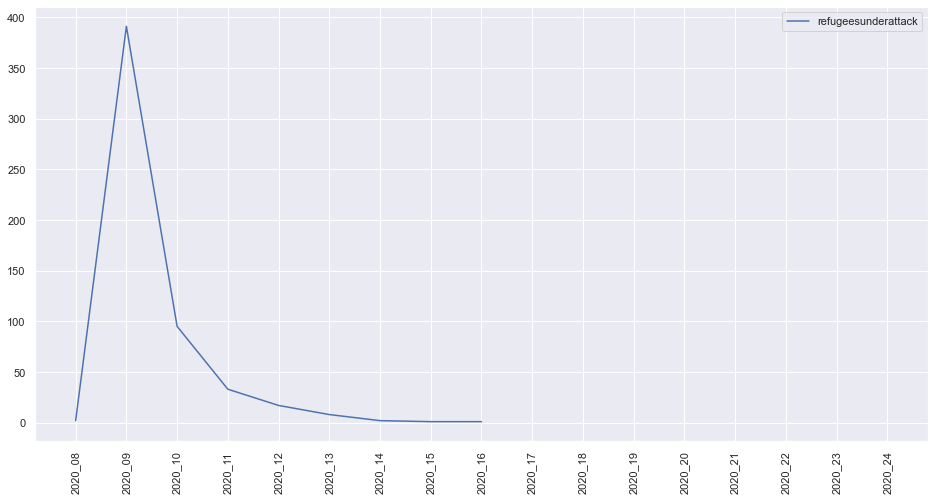

refugeesunderattack 701
refugees 341
greece 251
greeceattacksrefugees 181
europe 159
greek 145
turkey 142
idlib 137
greeceunderattack 128
greekborder 128
humanrightsviolations 128
murderergreeks 125
fuxkgreece 125
twofacedeu 124
coronavirus 124

------------------------------------------



In [410]:
hashtag_check(df_tweets,["refugeesunderattack"],"hashtags")

In [411]:
df_tweets_greece_2 = df_tweets_greece[df_tweets_greece["hashtags"].apply(lambda x: element_in_list(x,greece_hashtags_2))]
df_tweets_greece_2.shape

(36521, 25)

In [412]:
hashtag_count = get_entity_count(df_tweets_greece_2["hashtags"])

# Remove hashtags that are already in list
for hashtag in seen_hashtags:
    hashtag_count.pop(hashtag)

# Sort hashtags by frequency
hashtag_count_sorted = sorted(hashtag_count.items(), key=lambda x: x[1], reverse=True)
hashtag_count_sorted[:25]

[('refugeecrisis', 453),
 ('turkishpropaganda', 442),
 ('immigration', 436),
 ('turkeyisaterrorstate', 432),
 ('breaking', 431),
 ('un', 427),
 ('covid19', 404),
 ('migrant', 386),
 ('iran', 385),
 ('humanrightsrefugee', 358),
 ('ŒµŒ≤œÅŒøœÇ', 357),
 ('standwithgreece', 354),
 ('europeunderattack', 351),
 ('istandwithgrecee', 343),
 ('putin', 340),
 ('greekborders', 330),
 ('moria', 314),
 ('libya', 310),
 ('france', 290),
 ('bulgaria', 289),
 ('unhcr', 288),
 ('humanrightsviolations', 286),
 ('migrantcrisis', 282),
 ('greece_under_attacŒ∫', 275),
 ('asylum', 272)]

In [413]:
greece_hashtags_3 = greece_hashtags_2 + ["turkishpropaganda","turkeyisaterrorstate","standwithgreece","europeunderattack",
                                         "istandwithgrecee","greekborders","moria","bulgaria","greece_under_attacŒ∫"]

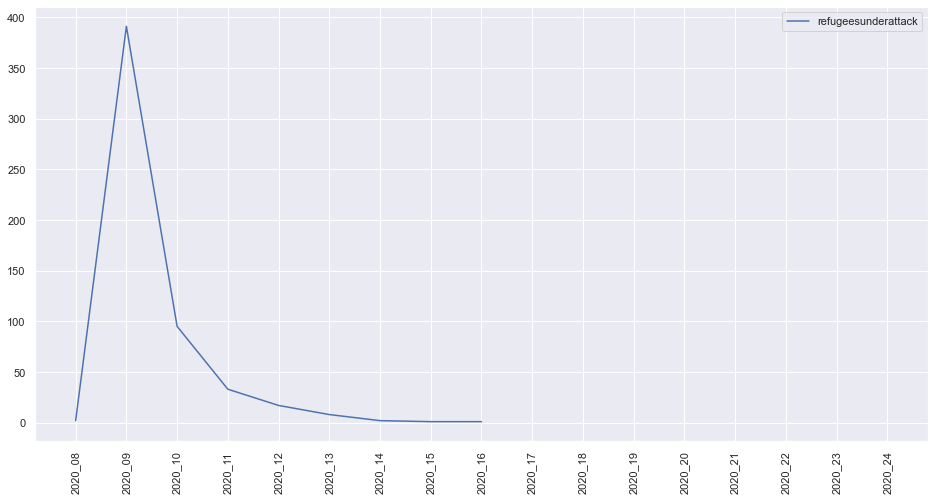

refugeesunderattack 701
refugees 341
greece 251
greeceattacksrefugees 181
europe 159
greek 145
turkey 142
idlib 137
greeceunderattack 128
greekborder 128
humanrightsviolations 128
murderergreeks 125
fuxkgreece 125
twofacedeu 124
coronavirus 124

------------------------------------------



In [414]:
hashtag_check(df_tweets,["refugeesunderattack"],"hashtags")

In [415]:
df_tweets_greece_3 = df_tweets_greece[df_tweets_greece["hashtags"].apply(lambda x: element_in_list(x,greece_hashtags_3))]
df_tweets_greece_3.shape

(37572, 25)

In [416]:
greece_hashtag_qualifier = greece_hashtags_3

#### Create event qualifier

In [417]:
annotation_count = get_entity_count(df_tweets_greece_3["annotations"])

# Sort hashtags by frequency
annotation_count_sorted = sorted(annotation_count.items(), key=lambda x: x[1], reverse=True)
annotation_count_sorted[:25]

[('turkey', 7242),
 ('greece', 5855),
 ('europe', 4756),
 ('syria', 2037),
 ('eu', 1598),
 ('erdogan', 1478),
 ('turkish', 713),
 ('idlib', 538),
 ('assad', 482),
 ('russia', 455),
 ('germany', 343),
 ('syrian', 315),
 ('nato', 299),
 ('pakistan', 280),
 ('lesbos', 276),
 ('united states', 269),
 ('ankara', 268),
 ('afghanistan', 265),
 ('state department', 255),
 ('iran', 213),
 ('syrians', 200),
 ('us', 193),
 ('edirne', 191),
 ('bulgaria', 189),
 ('putin', 178)]

In [418]:
greece_annotation_qualifier = ["turkey","greece","europe","syria","eu","erdogan","turkish","idlib","assad","syrian",
                               "nato","lesbos","ankara","syrians","edirne","bulgaria"]

In [419]:
mention_count = get_entity_count(df_tweets_greece_3["mentions"])

# Sort hashtags by frequency
mention_count_sorted = sorted(mention_count.items(), key=lambda x: x[1], reverse=True)
mention_count_sorted[:25]

[('refugees', 697),
 ('eu_commission', 582),
 ('vonderleyen', 476),
 ('un', 469),
 ('primeministergr', 372),
 ('secpompeo', 302),
 ('rterdogan', 295),
 ('eucopresident', 291),
 ('hrw', 286),
 ('amnesty', 229),
 ('nytimes', 226),
 ('nato', 220),
 ('reuters', 190),
 ('realdonaldtrump', 185),
 ('unhumanrights', 171),
 ('kmitsotakis', 164),
 ('antonioguterres', 163),
 ('bbcworld', 162),
 ('basedpoland', 132),
 ('europarl_en', 126),
 ('john_wayne_gr', 123),
 ('guyverhofstadt', 114),
 ('guardian', 112),
 ('emmanuelmacron', 111),
 ('skynews', 110)]

In [420]:
greece_mention_qualifier = []

#### Create event dataset

In [421]:
greece_qualifier = set(greece_hashtag_qualifier + greece_annotation_qualifier)

In [422]:
df_tweets_greece_final = df_tweets_greece[df_tweets_greece["text_clean"].apply(lambda x: element_in_list(x.split(" "),greece_qualifier))]
df_tweets_greece_final = df_tweets_greece_final.append(df_tweets_greece_3).drop_duplicates(subset=["id"])

In [423]:
df_tweets_greece_final.shape

(175900, 25)

#### Visualize event

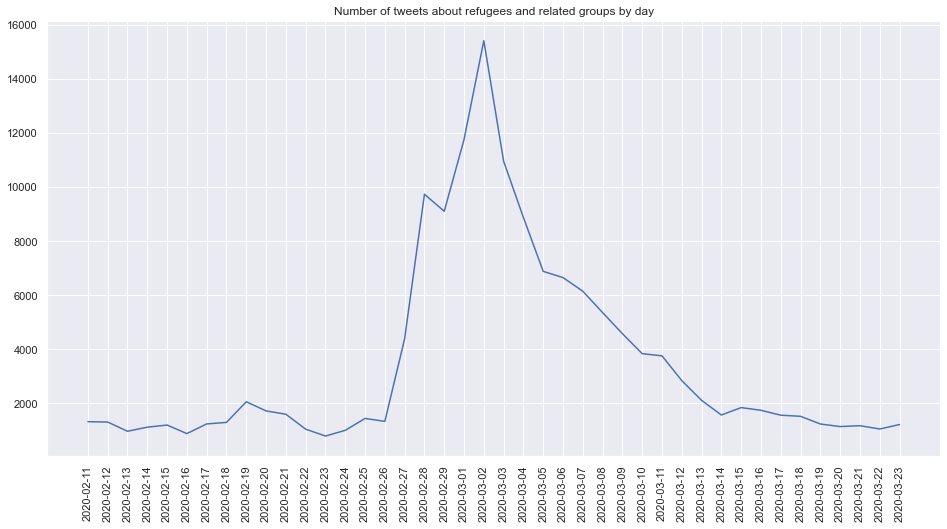

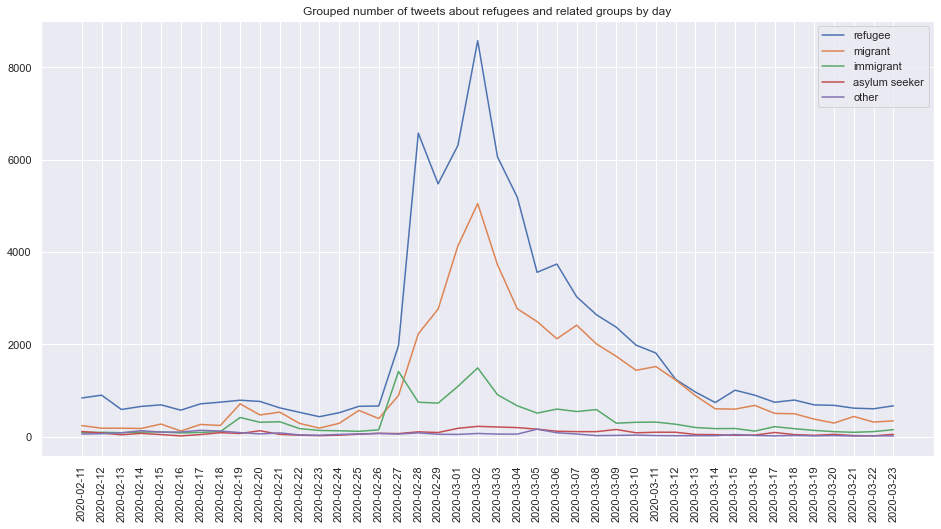

In [314]:
plot_event_timeline(df_tweets_greece_final,"day")

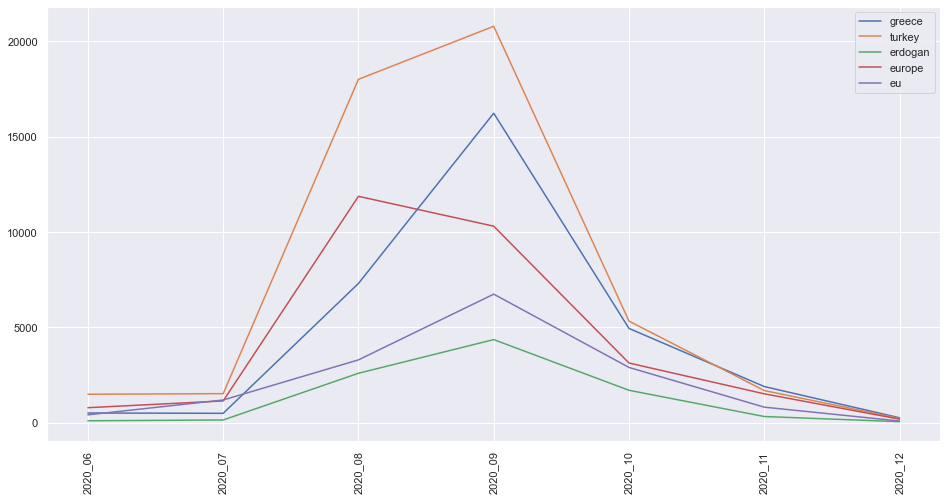

In [315]:
plot_entity_timeline(df_tweets_greece_final, "week", ["greece","turkey","erdogan","europe","eu"], "annotations")

In [316]:
df_tweets_greece_final.iloc[84020,1]

'Marios Lolos has captured the ethical crisis through his camera. @kmitsotakis @tsipras_eu @hrw @BBCWorld Photos taken in Greece this week. Zero plan for a humanised approach. Locals promised fake solutions while refugees denied education, work, movement to mainland/other country https://t.co/0IoWWEozCl'

In [424]:
df_tweets_greece_final.shape

(175900, 25)

#### Export the dataset as csv

In [317]:
greece_path = FILE_PATH + "\Event Dataframes\df_greece.csv"

In [318]:
df_tweets_greece_final.to_csv(greece_path)

---

### Tigray (5/2021, 12/2021, 15/2021)

In [110]:
df_hashtags_week["2021_05"]

0                        tigraygenocide
1                                tigray
2                   allowaccesstotigray
3     tigraiopen4humanitarianassistance
4                  uplifttigraiethiopia
5                  stoptheliehelptigrai
6                            unscactnow
7                         trudeauactnow
8                    eritreaoutoftigray
9                              refugees
10                             ethiopia
11                     unityforethiopia
12                                 tplf
13                              eritrea
14                          bidenactnow
Name: 2021_05, dtype: object

In [115]:
df_annotations_week["2021_05"]

0        tigray
1       eritrea
2         biden
3         sudan
4      ethiopia
5        turkey
6            us
7         trump
8       myanmar
9       america
10           un
11       canada
12     shimelba
13         u.s.
14    joe biden
Name: 2021_05, dtype: object

In [15]:
df_tweets_tigray = df_tweets[(df_tweets["created_at"] < "2021-05-01") & (df_tweets["created_at"] > "2021-01-15")]

In [16]:
tigray_hashtags_1 = ["tigraygenocide","tigray","allowaccesstotigray","tigraiopen4humanitarianassistance",
                     "uplifttigraiethiopia","stoptheliehelptigrai","unscactnow","trudeauactnow","eritreaoutoftigray",
                     "ethiopia","unityforethiopia","tplf","eritrea","bidenactnow","nzgovtactnow","evacuateeritreanrefugees",
                     "unhcractnow","sudan"]

In [17]:
df_tweets_tigray_1 = df_tweets_tigray[df_tweets_tigray["hashtags"].apply(lambda x: element_in_list(x,tigray_hashtags_1))]
df_tweets_tigray_1.shape

(133355, 25)

In [18]:
hashtag_count = get_entity_count(df_tweets_tigray_1["hashtags"])

# Remove hashtags that are already in list
for hashtag in tigray_hashtags_1:
    hashtag_count.pop(hashtag)

# Sort hashtags by frequency
hashtag_count_sorted = sorted(hashtag_count.items(), key=lambda x: x[1], reverse=True)
hashtag_count_sorted[:25]

[('befairunsc', 7336),
 ('bidentakeaction', 6992),
 ('stopwarontigray', 4508),
 ('eritrean', 4218),
 ('tigraycantwait', 4134),
 ('uninvestigatetigray', 4092),
 ('shameonamnesty', 3811),
 ('ausgovactnow', 3613),
 ('warontigray', 2623),
 ('nzgovactnow', 2486),
 ('refugees', 2432),
 ('ethiopiaprevails', 2326),
 ('isaias', 1865),
 ('irobmassacre', 1826),
 ('italygunsintigray', 1815),
 ('humanitariancorridor', 1616),
 ('tigraygenoicde', 1614),
 ('tigraya', 1606),
 ('unsc', 1572),
 ('tigrayans', 1572),
 ('ethiopian', 1520),
 ('abiymustgo', 1485),
 ('amhara', 1469),
 ('un', 1457),
 ('fakeaxummassacre', 1453)]

In [19]:
tigray_hashtags_2 = tigray_hashtags_1 + ["befairunsc","bidentakeaction","stopwarontigray","eritrean","tigraycantwait",
                                         "uninvestigatetigray","shameonamnesty","ausgovactnow","warontigray","nzgovactnow",
                                         "ethiopiaprevails","isaias","irobmassacre","italygunsintigray","humanitariancorridor",
                                         "tigraygenoicde","tigraya","tigrayans","ethiopian","abiymustgo","amhara","fakeaxummassacre"]

In [20]:
seen_hashtags = set([hashtag for hashtag,count in hashtag_count_sorted[:25]] + tigray_hashtags_2)

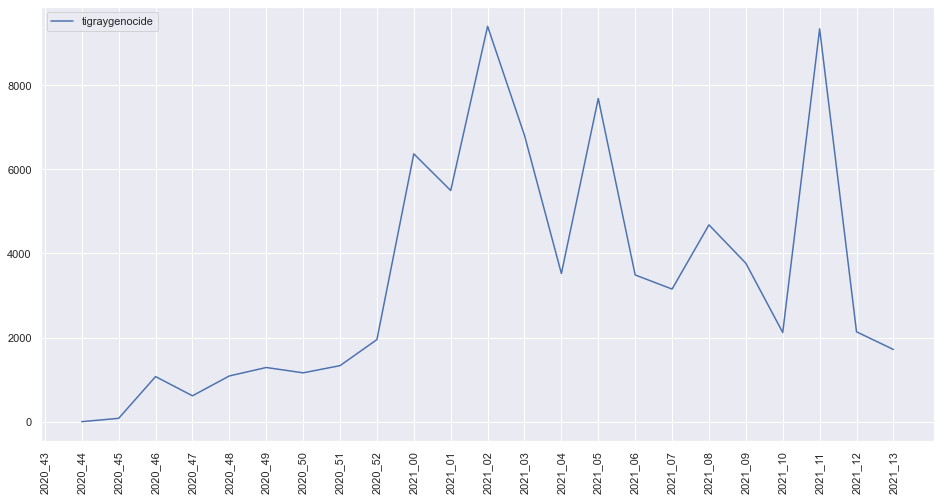

tigraygenocide 94472
tigray 33113
stopwarontigray 17768
bidenactnow 10429
allowaccesstotigray 9594
ethiopia 9193
unscactnow 7302
bidentakeaction 6225
eritrea 5394
stopabiy 3720
tigraycantwait 3492
trudeauactnow 3121
ausgovactnow 3121
sudan 2974
eritreaoutoftigray 2967

------------------------------------------



In [103]:
hashtag_check(df_tweets,["tigraygenocide"],"hashtags")

In [21]:
df_tweets_tigray_2 = df_tweets_tigray[df_tweets_tigray["hashtags"].apply(lambda x: element_in_list(x,tigray_hashtags_2))]
df_tweets_tigray_2.shape

(141929, 25)

In [22]:
hashtag_count = get_entity_count(df_tweets_tigray_2["hashtags"])

# Remove hashtags that are already in list
for hashtag in seen_hashtags:
    hashtag_count.pop(hashtag)

# Sort hashtags by frequency
hashtag_count_sorted = sorted(hashtag_count.items(), key=lambda x: x[1], reverse=True)
hashtag_count_sorted[:25]

[('amnestyusedtplfsources', 2434),
 ('maikadramassacre', 1689),
 ('unhcr', 1444),
 ('trudeaufailedtigray', 1425),
 ('abiytoicc', 1410),
 ('canada', 1396),
 ('euactnow', 1388),
 ('kunamastarvation', 1351),
 ('100daysofgenocide', 1348),
 ('verifiedwithdrawaloferitrea', 1328),
 ('stopstarvingtigray', 1275),
 ('boycottethiopianroses', 1172),
 ('famine', 1097),
 ('eu', 1073),
 ('superbowl', 1046),
 ('eritreantroopsoutoftigray', 1024),
 ('unscsupportethiopia', 984),
 ('maikadra', 943),
 ('samri', 900),
 ('weaponizedrape', 882),
 ('famineontigray', 851),
 ('samre', 847),
 ('sanctionethiopia', 834),
 ('amharaoutoftigray', 832),
 ('istandwithtigray', 805)]

In [23]:
tigray_hashtags_3 = tigray_hashtags_2 + ["amnestyusedtplfsources","maikadramassacre","trudeaufailedtigray","abiytoicc",
                                         "euactnow","kunamastarvation","100daysofgenocide","verifiedwithdrawaloferitrea",
                                         "stopstarvingtigray","boycottethiopianroses","eritreantroopsoutoftigray",
                                         "unscsupportethiopia","maikadra","samri","weaponizedrape","famineontigray",
                                         "sanctionethiopia","amharaoutoftigray","istandwithtigray"]

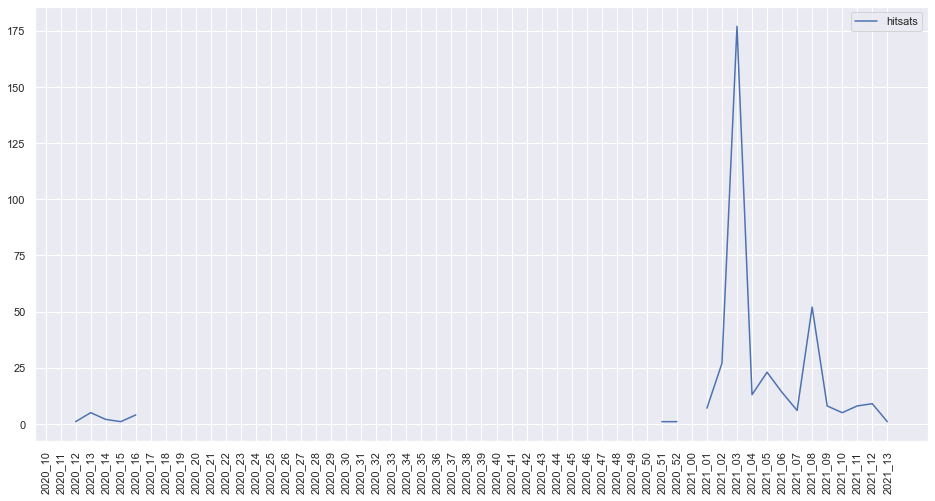

hitsats 380
tigraygenocide 194
shimelba 129
ethiopia 58
tplf 57
eritrea 56
tigray 52
eritrean 50
adiharush 41
maiaini 37
standwithethiopia 34
gonder 13
tigrai 13
refugees 11
stopwarontigray 8

------------------------------------------



In [79]:
hashtag_check(df_tweets,["hitsats"],"hashtags")

In [24]:
df_tweets_tigray_3 = df_tweets_tigray[df_tweets_tigray["hashtags"].apply(lambda x: element_in_list(x,tigray_hashtags_3))]
df_tweets_tigray_3.shape

(146668, 25)

In [25]:
tigray_hashtag_qualifier = tigray_hashtags_3

#### Create event qualifier

In [26]:
annotation_count = get_entity_count(df_tweets_tigray_3["annotations"])

# Sort hashtags by frequency
annotation_count_sorted = sorted(annotation_count.items(), key=lambda x: x[1], reverse=True)
annotation_count_sorted[:25]

[('tigray', 28525),
 ('ethiopia', 26075),
 ('sudan', 17975),
 ('eritrea', 16134),
 ('shimelba', 4666),
 ('hitsats', 3243),
 ('un', 2489),
 ('eritrean', 1722),
 ('ethiopian', 1717),
 ('shire', 1696),
 ('amnesty international', 1653),
 ('isaias afewerki', 1598),
 ('tigray refugee camps', 1576),
 ('united nations', 1497),
 ('hamdayet', 1477),
 ('eu', 1268),
 ('italy', 1174),
 ('tigrayans', 1154),
 ('unsc', 1121),
 ('europe', 1094),
 ('daniel bekele', 1093),
 ('mekele', 1074),
 ('irob advocacy association', 1069),
 ('canada', 922),
 ('norwegian refugee council', 901)]

In [27]:
tigray_annotation_qualifier = ["tigray","ethiopia","eritrea","shimelba","hitsats","eritrean","ethiopian","shire",
                               "tigrayans","afewerki","hamdayet","tigrayans","bekele","mekele"]

In [28]:
mention_count = get_entity_count(df_tweets_tigray_3["mentions"])

# Sort hashtags by frequency
mention_count_sorted = sorted(mention_count.items(), key=lambda x: x[1], reverse=True)
mention_count_sorted[:25]

[('refugees', 38087),
 ('un', 36061),
 ('eu_commission', 25777),
 ('secblinken', 21581),
 ('potus', 20221),
 ('hrw', 18677),
 ('amnesty', 16354),
 ('joebiden', 15828),
 ('lindat_g', 15422),
 ('abiyahmedali', 13123),
 ('unscouncil', 11169),
 ('unhumanrights', 9734),
 ('vp', 9473),
 ('ablinken', 8588),
 ('antonioguterres', 8206),
 ('justintrudeau', 7848),
 ('statedept', 7770),
 ('intlcrimcourt', 6874),
 ('marcgarneau', 6634),
 ('kamalaharris', 6316),
 ('usun', 6080),
 ('josepborrellf', 5807),
 ('chriscoons', 5756),
 ('senbooker', 5746),
 ('unocha', 5494)]

In [29]:
tigray_mention_qualifier = []

#### Create event dataset

In [30]:
tigray_qualifier = set(tigray_hashtag_qualifier + tigray_annotation_qualifier)

In [31]:
df_tweets_tigray_final = df_tweets_tigray[df_tweets_tigray["text_clean"].apply(lambda x: element_in_list(x.split(" "),tigray_qualifier))]
df_tweets_tigray_final = df_tweets_tigray_final.append(df_tweets_tigray_3).drop_duplicates(subset=["id"])

In [32]:
df_tweets_tigray_final.shape

(181715, 25)

#### Visualize event

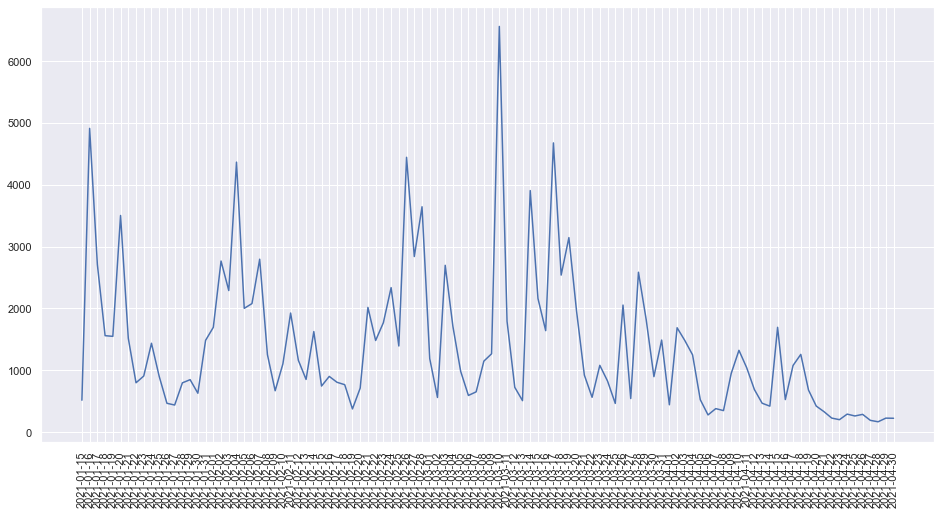

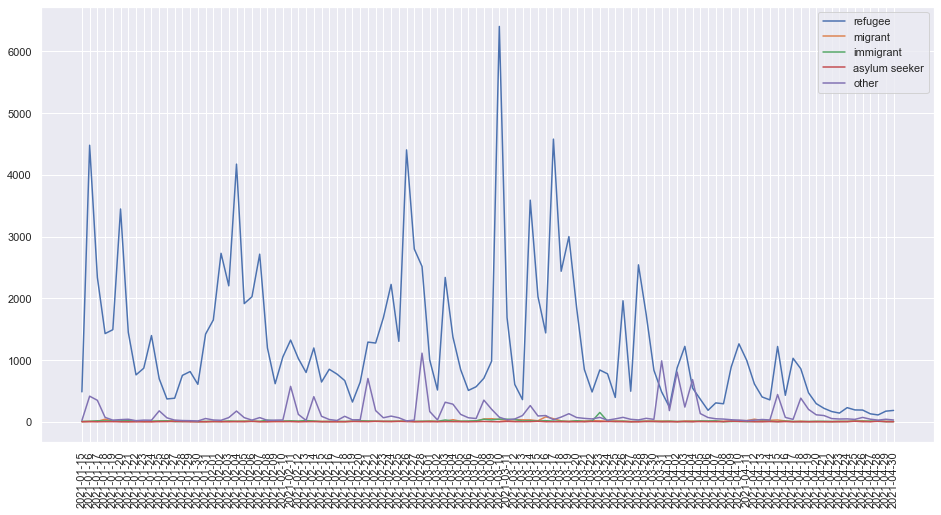

In [33]:
plot_event_timeline(df_tweets_tigray_final,"day")

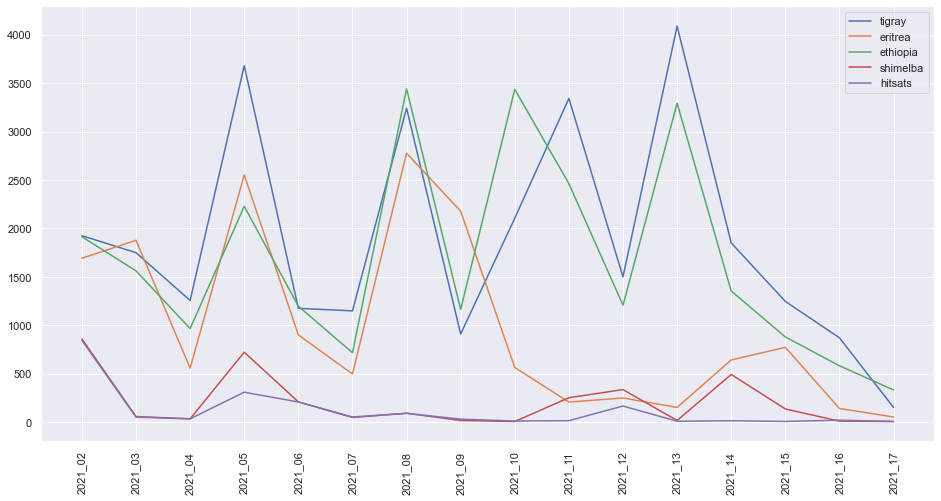

In [35]:
plot_entity_timeline(df_tweets_tigray_final, "week", ["tigray","eritrea","ethiopia","shimelba","hitsats"], "annotations")

In [36]:
df_tweets_tigray_final.iloc[25230,1]

'The UK says killers in Ethiopia ‚Äúmust be held to account, whoever they may be‚Äù and responds to call that eye witness statements are taken from refugees from Tigray about reports of war crimes and crimes against humanity in that region. https://t.co/wZzhsbFc8d'

In [37]:
df_tweets_tigray_final.shape

(181715, 25)

#### Export the dataset as csv

In [38]:
tigray_path = FILE_PATH + "\Event Dataframes\df_tigray.csv"

In [39]:
df_tweets_tigray_final.to_csv(tigray_path)

---

### Rohingya (12&15/2021)

In [16]:
df_hashtags_week["2021_12"]

0      whatshappeninginmyanmar
1               tigraygenocide
2                      eritrea
3                    mar26coup
4                  nzgovactnow
5     evacuateeritreanrefugees
6                     refugees
7                     rohingya
8                  unhcractnow
9                    mar28coup
10                     refugee
11                  bangladesh
12            unityforethiopia
13          eritreaoutoftigray
14           amharaoutoftigray
Name: 2021_12, dtype: object

In [15]:
df_hashtags_week["2021_15"]

0     whatshappeninginmyanmar
1                   apr18coup
2                   apr17coup
3                wesupportnug
4           apr16silentstrike
5                   apr14coup
6              tigraygenocide
7                    refugees
8         releasethedetainees
9                       sudan
10                  tigrayans
11                  abiytoicc
12         noflyzoneinmyanmar
13                 unscactnow
14                   rohingya
Name: 2021_15, dtype: object

In [40]:
df_tweets_roh = df_tweets[(df_tweets["created_at"] < "2021-05-01") & (df_tweets["created_at"] > "2021-03-01")]

In [41]:
df_tweets_roh.shape

(2077140, 25)

In [42]:
roh_hashtags_1 = ["whatshappeninginmyanmar","apr18coup","apr17coup","wesupportnug","apr16silentstrike","apr14coup",
                  "releasethedetainees","noflyzoneinmyanmar","rohingya","mar26coup","mar28coup","bangladesh"]

In [43]:
df_tweets_roh_1 = df_tweets_roh[df_tweets_roh["hashtags"].apply(lambda x: element_in_list(x,roh_hashtags_1))]
df_tweets_roh_1.shape

(118548, 25)

In [44]:
hashtag_count = get_entity_count(df_tweets_roh_1["hashtags"])

# Remove hashtags that are already in list
for hashtag in roh_hashtags_1:
    hashtag_count.pop(hashtag)

# Sort hashtags by frequency
hashtag_count_sorted = sorted(hashtag_count.items(), key=lambda x: x[1], reverse=True)
hashtag_count_sorted[:25]

[('apr25coup', 7679),
 ('karen', 6822),
 ('mar18coup', 6475),
 ('aseansupportnug', 5962),
 ('myanmar', 5741),
 ('apr26coup', 5136),
 ('milkteaalliance', 4990),
 ('apr4coup', 4959),
 ('apr12coup', 4452),
 ('crimesagainsthumanity', 4404),
 ('mar31coup', 4324),
 ('internetshutdown', 4278),
 ('apr19coup', 4066),
 ('mar30coup', 3846),
 ('myanmarmilitary', 3614),
 ('apr30coup', 3590),
 ('hearthevoiceofmyanmar', 3584),
 ('apr24coup', 3369),
 ('rohingyasolidarity', 3234),
 ('apr20coup', 2700),
 ('apr21coup', 2575),
 ('aseanrejectsac', 2426),
 ('apr22coup', 2283),
 ('apr2coup', 1967),
 ('eastereggstrike', 1887)]

In [45]:
roh_hashtags_2 = roh_hashtags_1 + ["apr25coup","karen","mar18coup","aseansupportnug","myanmar","apr26coup","apr4coup","milkteaalliance",
                                   "apr12coup","mar31coup","myanmarmilitary","apr30coup","hearthevoiceofmyanmar",
                                   "apr24coup","rohingyasolidarity","apr20coup","apr20coup","apr21coup","aseanrejectsac",
                                   "apr22coup","apr2coup","eastereggstrike","apr27coup","apr19coup","mar30coup"]

In [46]:
seen_hashtags = set([hashtag for hashtag,count in hashtag_count_sorted[:25]] + roh_hashtags_2)

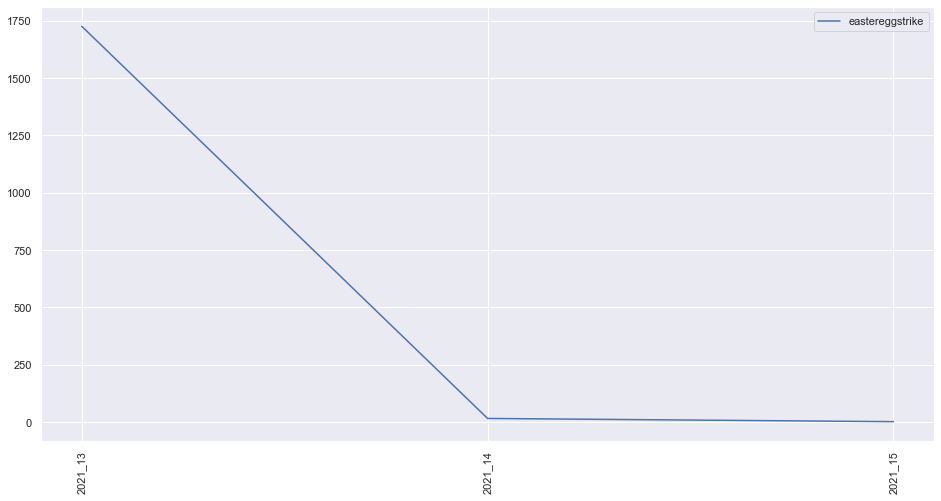

eastereggstrike 1906
whatshappeninginmyanmar 1869
apr4coup 1864
internetshutdown 24
whatshappeninglnmyanmar 12
milkteaalliance 9
karen 8
easter 6
myanmar 5
easter2021 5
savemyanmar 5
forceavote 4
yangon 4
springrevolutionmyanmar 3
kamaryut 3

------------------------------------------



In [247]:
hashtag_check(df_tweets,["eastereggstrike"],"hashtags")

In [47]:
df_tweets_roh_2 = df_tweets_roh[df_tweets_roh["hashtags"].apply(lambda x: element_in_list(x,roh_hashtags_2))]
df_tweets_roh_2.shape

(123037, 25)

In [48]:
hashtag_count = get_entity_count(df_tweets_roh_2["hashtags"])

# Remove hashtags that are already in list
for hashtag in seen_hashtags:
    hashtag_count.pop(hashtag)

# Sort hashtags by frequency
hashtag_count_sorted = sorted(hashtag_count.items(), key=lambda x: x[1], reverse=True)
hashtag_count_sorted[:25]

[('whatshappeninglnmyanmar', 2118),
 ('mar10coup', 1789),
 ('forceavote', 1705),
 ('greendaystrike', 1617),
 ('mar29coup', 1608),
 ('apr6coup', 1500),
 ('apr28coup', 1343),
 ('noflyzone', 1325),
 ('apr23coup', 1266),
 ('apr15coup', 1175),
 ('refugees', 1036),
 ('mar16coup', 973),
 ('mar17coup', 947),
 ('apr29coup', 897),
 ('apr3coup', 888),
 ('releasetheabductees', 883),
 ('thailand', 751),
 ('refugee', 726),
 ('apr1coup', 618),
 ('apr11coup', 604),
 ('india', 588),
 ('apr13coup', 575),
 ('savemyanmar', 567),
 ('opccp', 523),
 ('apr5coup', 490)]

In [49]:
roh_hashtags_3 = roh_hashtags_2 + ["whatshappeninglnmyanmar","mar10coup","forceavote","greendaystrike","mar29coup","apr6coup",
                                   "apr28coup","noflyzone","apr23coup","apr15coup","apr29coup","apr3coup",
                                   "releasetheabductees","apr1coup","apr11coup","apr13coup","apr5coup","savemyanmar",
                                   "kachin","opccp","civildisobediencemovement","apr5coup"]

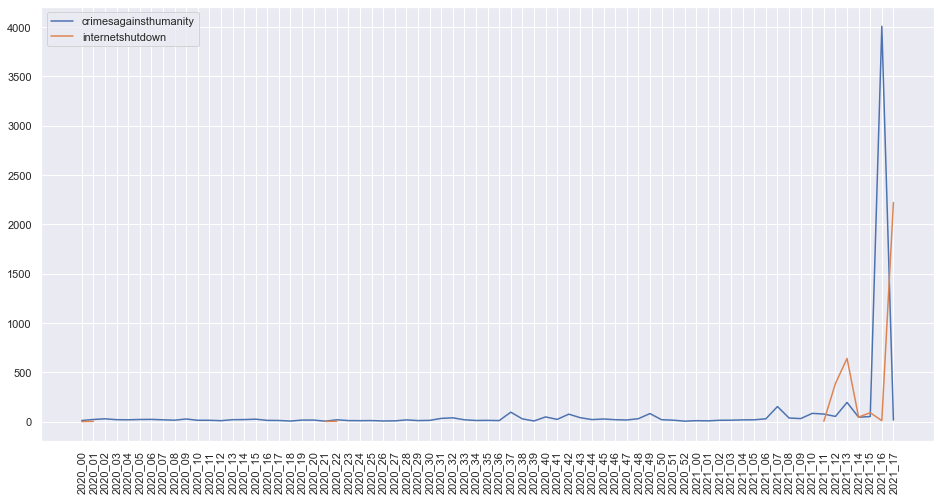

crimesagainsthumanity 6490
whatshappeninginmyanmar 4442
apr19coup 3973
refugees 327
genocide 218
myanmar 206
crimesagainstchildren 198
warcrimes 191
ethniccleansing 157
rohingya 154
migrants 152
un 150
humanity 145
unhcr 138
milkteaalliance 138

------------------------------------------

internetshutdown 4358
whatshappeninginmyanmar 4274
apr30coup 2210
apr2coup 1305
milkteaalliance 106
apr4coup 90
apr3coup 48
myanmar 39
karen 39
opccp 34
issueinterimconstitution 32
apr12coup 32
noflyzone 31
apr1coup 30
crimesagainsthumanity 29

------------------------------------------



In [258]:
hashtag_check(df_tweets,["crimesagainsthumanity","internetshutdown"],"hashtags")

In [50]:
df_tweets_roh_3 = df_tweets_roh[df_tweets_roh["hashtags"].apply(lambda x: element_in_list(x,roh_hashtags_3))]
df_tweets_roh_3.shape

(125795, 25)

In [51]:
roh_hashtag_qualifier = roh_hashtags_3

#### Create event qualifier

In [52]:
annotation_count = get_entity_count(df_tweets_roh_3["annotations"])

# Sort hashtags by frequency
annotation_count_sorted = sorted(annotation_count.items(), key=lambda x: x[1], reverse=True)
annotation_count_sorted[:25]

[('myanmar', 48682),
 ('thailand', 15357),
 ('bangladesh', 9250),
 ('kachin state', 7561),
 ('kia', 7166),
 ('karen refugees', 6410),
 ('karen', 4940),
 ('mutraw district', 4881),
 ('texas', 4668),
 ('america', 4666),
 ('chicago', 4323),
 ('new jersey', 4169),
 ('yangon', 3958),
 ('fort worth', 3864),
 ('moemauk', 3752),
 ('god', 3503),
 ('burma', 3472),
 ('cdm', 3445),
 ('seoul catholic students', 3038),
 ('teinnyo', 3025),
 ('mutayaw', 3014),
 ('kayin', 2931),
 ('ambassador ukyawmoetun', 2877),
 ('australia', 2716),
 ('melbourne', 2691)]

In [53]:
roh_annotation_qualifier = ["myanmar","thailand","bangladesh","kia","kachin","karen","mutraw","moemauk","mutayaw","kayin",
                            "kachin","teinnyo"]

In [54]:
mention_count = get_entity_count(df_tweets_roh_3["mentions"])

# Sort hashtags by frequency
mention_count_sorted = sorted(mention_count.items(), key=lambda x: x[1], reverse=True)
mention_count_sorted[:25]

[('nugmyanmar', 7073),
 ('refugees', 5761),
 ('rapporteurun', 5603),
 ('un', 4794),
 ('milkteath_mtat', 3854),
 ('ukinmyanmar', 3608),
 ('usun', 3592),
 ('euatun', 3566),
 ('un_hrc', 3214),
 ('freya_cole', 2108),
 ('kenroth', 1741),
 ('tostevinm', 1480),
 ('unicef', 1078),
 ('cij_icj', 1075),
 ('schranerburgen1', 1072),
 ('mfathai', 1006),
 ('uninmyanmar', 888),
 ('unhumanrights', 878),
 ('save_children', 825),
 ('usembassyburma', 799),
 ('unicefchief', 733),
 ('poppymcp', 695),
 ('cnn', 651),
 ('asean', 537),
 ('antonioguterres', 514)]

In [55]:
roh_mention_qualifier = []

#### Create event dataset

In [56]:
roh_qualifier = set(roh_hashtag_qualifier + roh_annotation_qualifier)

In [57]:
df_tweets_roh_final = df_tweets_roh[df_tweets_roh["text_clean"].apply(lambda x: element_in_list(x.split(" "),roh_qualifier))]
df_tweets_roh_final = df_tweets_roh_final.append(df_tweets_roh_3).drop_duplicates(subset=["id"])

In [58]:
df_tweets_roh_final.shape

(143176, 25)

#### Visualize event

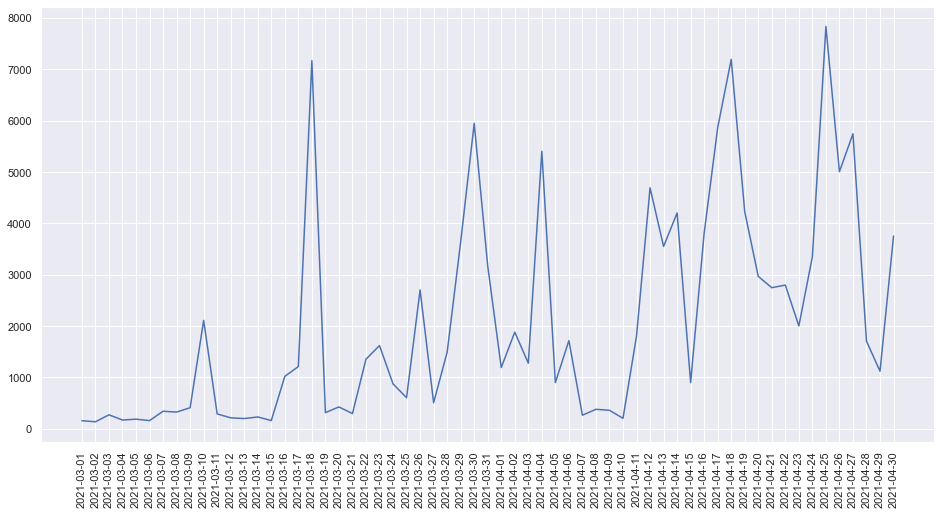

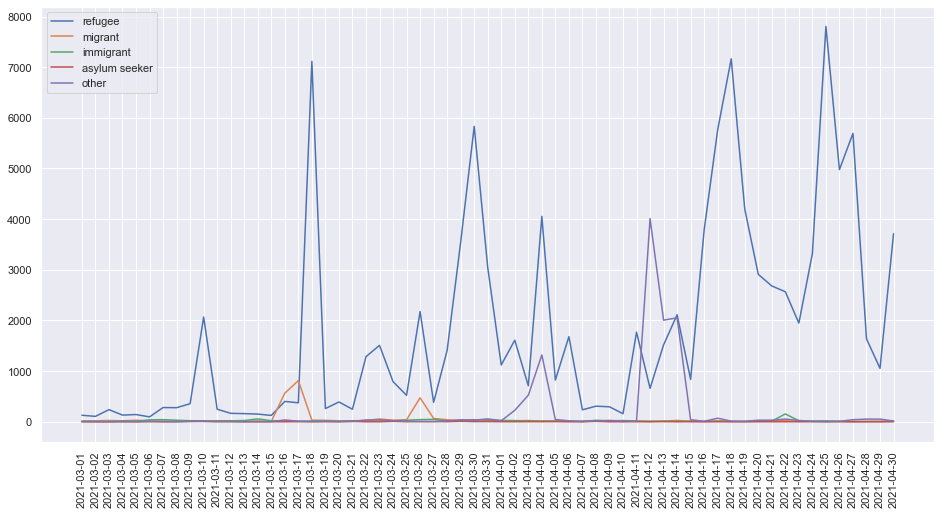

In [59]:
plot_event_timeline(df_tweets_roh_final,"day")

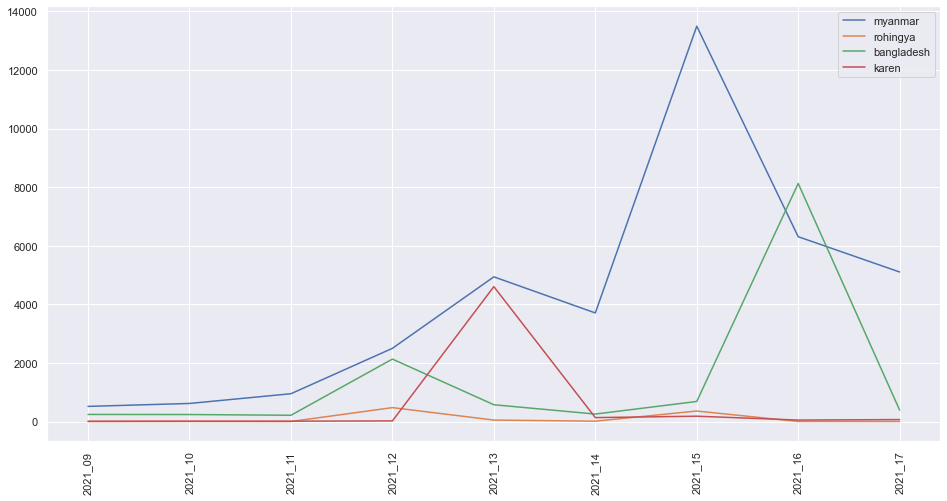

In [60]:
plot_entity_timeline(df_tweets_roh_final, "week", ["myanmar","rohingya","bangladesh","karen"], "annotations")

In [61]:
df_tweets_roh_final.iloc[25230,1]

'@MilkTeaTH_MTAT @AllianceMilkTea @poppymcp @YourAnonCentral @SecBlinken @antonioguterres \nPlease help Karen Refugees. They have NOWHERE else to go. üò¢\nPlease save our Karen people. They‚Äôve already suffered more than enough. üôèüèª\n#WhatsHappeningInMyanmar \n#Mar30Coup https://t.co/ol5hZPSgfh'

In [62]:
df_tweets_roh_final.shape

(143176, 25)

In [429]:
hashtag_count = get_entity_count(df_tweets_roh_final["hashtags"])

# Sort hashtags by frequency
hashtag_count_sorted = sorted(hashtag_count.items(), key=lambda x: x[1], reverse=True)
hashtag_count_sorted[:25]

[('whatshappeninginmyanmar', 101379),
 ('rohingya', 9280),
 ('apr25coup', 7692),
 ('karen', 7103),
 ('apr18coup', 7003),
 ('myanmar', 6823),
 ('aseansupportnug', 5967),
 ('apr17coup', 5669),
 ('milkteaalliance', 5310),
 ('wesupportnug', 5223),
 ('apr26coup', 5141),
 ('apr4coup', 5010),
 ('apr12coup', 4474),
 ('apr16silentstrike', 4470),
 ('crimesagainsthumanity', 4392),
 ('mar31coup', 4383),
 ('internetshutdown', 4325),
 ('apr19coup', 4123),
 ('mar30coup', 3981),
 ('apr21coup', 3739),
 ('noflyzoneinmyanmar', 3700),
 ('myanmarmilitary', 3637),
 ('apr30coup', 3607),
 ('hearthevoiceofmyanmar', 3601),
 ('apr24coup', 3379)]

#### Export the dataset as csv

In [63]:
roh_path = FILE_PATH + "\Event Dataframes\df_rohingya.csv"

In [65]:
df_tweets_roh_final.to_csv(roh_path)

---
## Unused Events

### Beirut Blast (32/2020)

In [356]:
df_hashtags_week["2020_32"]

0                   refugees
1            refugeeswelcome
2                      unhcr
3                   malaysia
4                    refugee
5                    covid19
6                  community
7     standwithiraqirefugees
8                       help
9                      peace
10               safepassage
11                  migrants
12                  children
13                      love
14                   lebanon
Name: 2020_32, dtype: object

In [357]:
df_tweets_beirut = df_tweets[(df_tweets["created_at"] < "2020-08-25") & (df_tweets["created_at"] > "2020-06-14")]

In [358]:
beirut_hashtags_1 = ["lebanon"]

In [359]:
df_tweets_beirut_1 = df_tweets_beirut[df_tweets_beirut["hashtags"].apply(lambda x: element_in_list(x,beirut_hashtags_1))]
df_tweets_beirut_1.shape

(1829, 25)

In [360]:
hashtag_count = get_entity_count(df_tweets_beirut_1["hashtags"])

# Remove hashtags that are already in list
for hashtag in beirut_hashtags_1:
    hashtag_count.pop(hashtag)

# Sort hashtags by frequency
hashtag_count_sorted = sorted(hashtag_count.items(), key=lambda x: x[1], reverse=True)
hashtag_count_sorted[:25]

[('refugees', 324),
 ('beirut', 311),
 ('syria', 194),
 ('covid19', 142),
 ('refugee', 119),
 ('syrian', 105),
 ('beirutexplosion', 104),
 ('beirutblast', 94),
 ('jordan', 79),
 ('palestine', 72),
 ('abolishkafala', 50),
 ('iraq', 46),
 ('worldrefugeeday', 46),
 ('palestinian', 45),
 ('syriaconf2020', 41),
 ('kafala', 37),
 ('ŸÑÿ®ŸÜÿßŸÜ', 36),
 ('turkey', 36),
 ('coronavirus', 35),
 ('lebanonexplosion', 32),
 ('lebanese', 31),
 ('migrants', 31),
 ('ÿ®Ÿäÿ±Ÿàÿ™', 29),
 ('israel', 29),
 ('yemen', 27)]

In [361]:
beirut_hashtags_2 = beirut_hashtags_1 + ["beirut","beirutexplosion","beirutblast","abolishkafala","kafala","lebanonexplosion",
                                         "lebanese"]

In [362]:
seen_hashtags = set([hashtag for hashtag,count in hashtag_count_sorted[:25]] + beirut_hashtags_2)

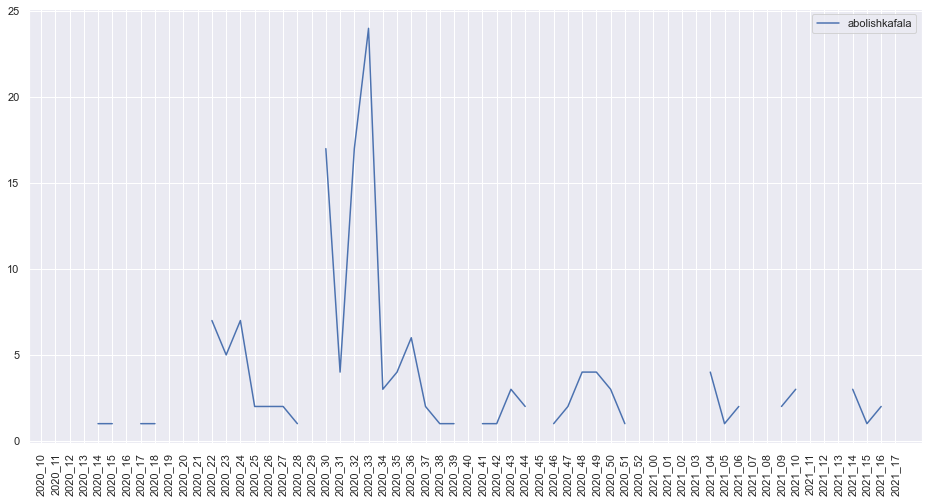

abolishkafala 167
lebanon 77
beirutexplosion 34
ÿ®Ÿäÿ±Ÿàÿ™ 30
ŸÑÿ®ŸÜÿßŸÜ 30
migrantdomesticworkers 29
ÿßŸÜŸÅÿ¨ÿßÿ±_ÿßŸÑŸÖÿ±ŸÅÿ£ 27
domesticworker 27
beirutblasts 24
sendushome 21
standup4humanrights 19
womenforwomen 14
blacklivesmatter 9
kafala 7
intersectionalfeminism 6

------------------------------------------



In [363]:
hashtag_check(df_tweets,["abolishkafala"],"hashtags")

In [364]:
df_tweets_beirut_2 = df_tweets_beirut[df_tweets_beirut["hashtags"].apply(lambda x: element_in_list(x,beirut_hashtags_2))]
df_tweets_beirut_2.shape

(2808, 25)

In [365]:
hashtag_count = get_entity_count(df_tweets_beirut_2["hashtags"])

# Remove hashtags that are already in list
for hashtag in seen_hashtags:
    hashtag_count.pop(hashtag)

# Sort hashtags by frequency
hashtag_count_sorted = sorted(hashtag_count.items(), key=lambda x: x[1], reverse=True)
hashtag_count_sorted[:25]

[('unhcr', 33),
 ('prayforlebanon', 31),
 ('migrantdomesticworkers', 29),
 ('ÿßŸÜŸÅÿ¨ÿßÿ±_ÿßŸÑŸÖÿ±ŸÅÿ£', 29),
 ('domesticworker', 29),
 ('standwithlebanon', 28),
 ('explosion', 27),
 ('beirutblasts', 26),
 ('iran', 25),
 ('migrantworkers', 23),
 ('ethiopia', 23),
 ('idlib', 22),
 ('libya', 22),
 ('withrefugees', 22),
 ('sendushome', 22),
 ('migrant', 21),
 ('humanrights', 21),
 ('covid_19', 21),
 ('beirut_explosion', 21),
 ('rt', 20),
 ('palestinerefugees', 20),
 ('beirutrtfund', 20),
 ('rohingya', 19),
 ('endkafala', 19),
 ('france', 19)]

In [366]:
beirut_hashtags_3 = beirut_hashtags_2 + ["prayforlebanon","standwithlebanon","explosion","beirutblasts","beirut_explosion",
                                         "beirutrtfund","endkafala"]

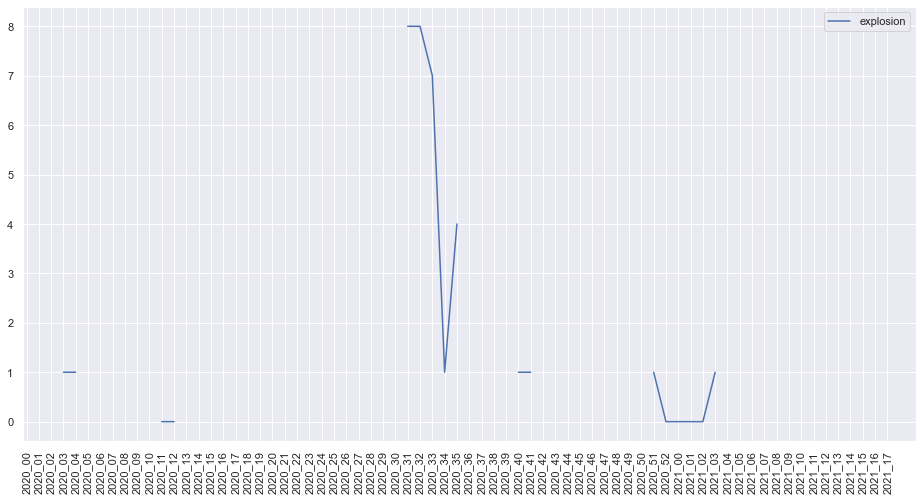

explosion 71
beirut 31
lebanon 23
nashville 16
refugees 15
beirutrtfund 14
news 13
beirutexplosion 11
charity 11
latest 10
recovery 10
blast 10
covid19 9
beirutprotests 9
beirutinourhearts 8

------------------------------------------



In [367]:
hashtag_check(df_tweets,["explosion"],"hashtags")

In [368]:
df_tweets_beirut_3 = df_tweets_beirut[df_tweets_beirut["hashtags"].apply(lambda x: element_in_list(x,beirut_hashtags_3))]
df_tweets_beirut_3.shape

(2893, 25)

In [369]:
beirut_hashtag_qualifier = beirut_hashtags_3

#### Create event qualifier

In [370]:
annotation_count = get_entity_count(df_tweets_beirut_3["annotations"])

# Sort hashtags by frequency
annotation_count_sorted = sorted(annotation_count.items(), key=lambda x: x[1], reverse=True)
annotation_count_sorted[:25]

[('lebanon', 515),
 ('beirut', 255),
 ('syria', 55),
 ('unrwa', 35),
 ('allah', 35),
 ('unhcr', 34),
 ('palestine', 32),
 ('us', 24),
 ('israel', 19),
 ('europe', 18),
 ('syrian', 16),
 ('uk', 14),
 ('un', 13),
 ('eu', 12),
 ('canada', 12),
 ('middle east', 11),
 ('god', 11),
 ('syrians', 11),
 ('hezbollah', 11),
 ('sama', 11),
 ('africa', 10),
 ('bekaa valley', 10),
 ('france', 10),
 ('libyan', 10),
 ('arsal', 9)]

In [375]:
beirut_annotation_qualifier = ["lebanon","beirut"]

In [372]:
mention_count = get_entity_count(df_tweets_beirut_3["mentions"])

# Sort hashtags by frequency
mention_count_sorted = sorted(mention_count.items(), key=lambda x: x[1], reverse=True)
mention_count_sorted[:25]

[('refugees', 140),
 ('filippograndi', 54),
 ('un', 52),
 ('unrwa', 29),
 ('unhcrlebanon', 28),
 ('unicef', 26),
 ('unmigration', 26),
 ('wfp', 18),
 ('hrw', 18),
 ('rescueorg', 17),
 ('arm_leb', 15),
 ('ajenglish', 15),
 ('redcrosslebanon', 14),
 ('ddabbous1', 13),
 ('who', 12),
 ('equalitynow', 12),
 ('change', 11),
 ('emmanuelmacron', 11),
 ('uniceflebanon', 10),
 ('basmehzeitooneh', 10),
 ('iomlebanon', 10),
 ('ajstream', 9),
 ('amnesty', 9),
 ('unocha', 9),
 ('egnalegnadwu', 8)]

In [373]:
beirut_mention_qualifier = []

#### Create event dataset

In [376]:
beirut_qualifier = set(beirut_hashtag_qualifier + beirut_annotation_qualifier)

In [377]:
df_tweets_beirut_final = df_tweets_beirut[df_tweets_beirut["text_clean"].apply(lambda x: element_in_list(x.split(" "),beirut_qualifier))]
df_tweets_beirut_final = df_tweets_beirut_final.append(df_tweets_beirut_3).drop_duplicates(subset=["id"])

In [379]:
df_tweets_beirut_final.shape

(12802, 25)

#### Visualize event

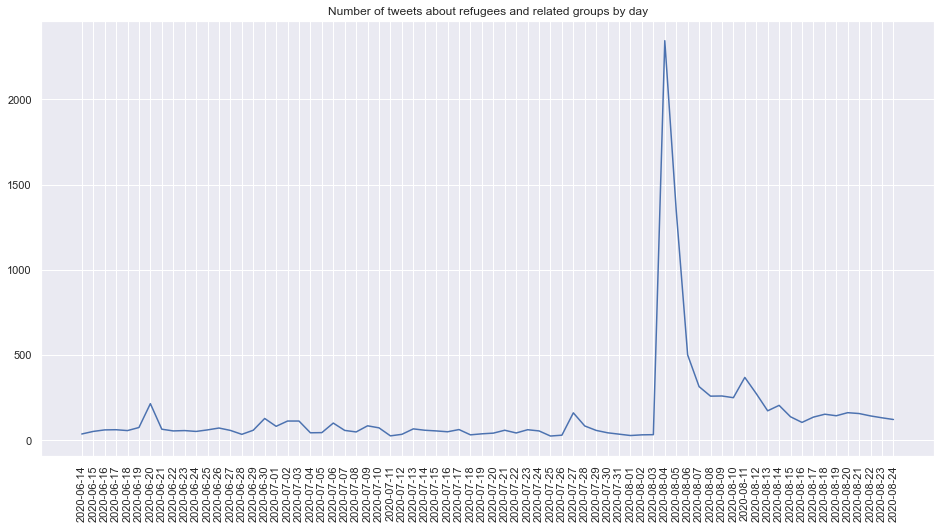

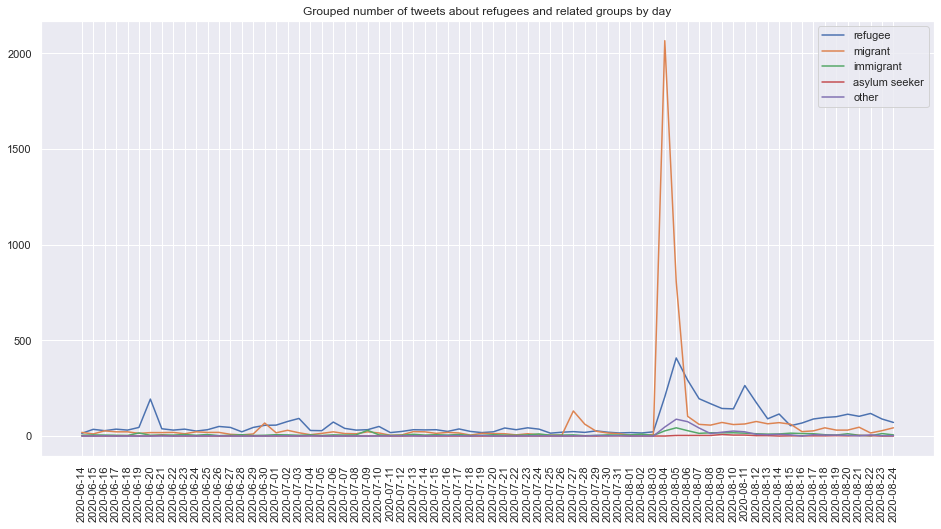

In [380]:
plot_event_timeline(df_tweets_beirut_final,"day")

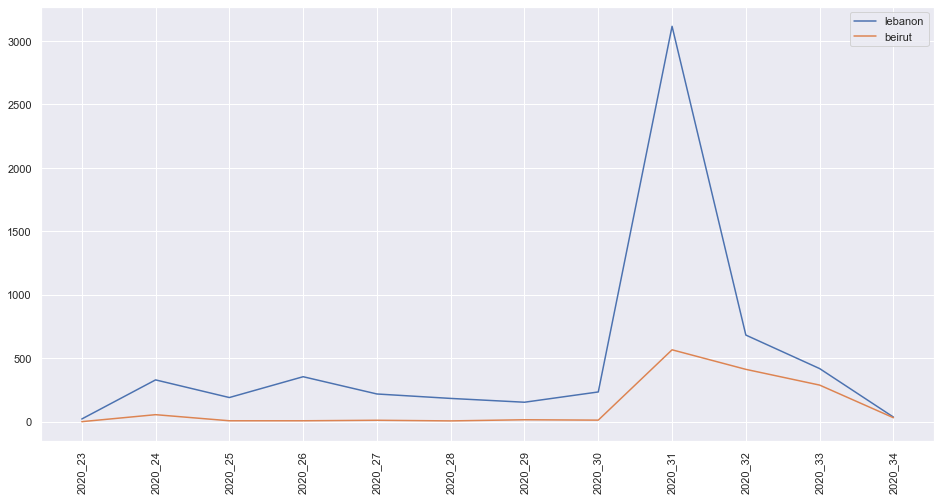

In [381]:
plot_entity_timeline(df_tweets_beirut_final, "week", ["lebanon","beirut"], "annotations")

In [382]:
df_tweets_beirut_final.iloc[2000,1]

'#‡§ú‡§®‡§∏‡§Ç‡§ñ‡•ç‡§Ø‡§æ_‡§®‡§ø‡§Ø‡§Ç‡§§‡•ç‡§∞‡§£_‡§Ö‡§ß‡•ç‡§Ø‡§æ‡§¶‡•á‡§∂\n\nPrime reasons for explosion in population growth\n\nIllegal immigrants from Bangladesh\n\nIllegal Rohingyas from Myanmar\n\nHum 2 humare 2 does not seem to apply\n\nSome believe in \nHum 4 hamare 14\n\n#PopulationControlLaw #‡§ú‡§®‡§∏‡§Ç‡§ñ‡•ç‡§Ø‡§æ_‡§®‡§ø‡§Ø‡§Ç‡§§‡•ç‡§∞‡§£_‡§ï‡§æ‡§®‡•Å‡§®'

#### Export the dataset as csv

In [384]:
beirut_path = FILE_PATH + "\Event Dataframes\df_beirut.csv"

In [385]:
df_tweets_beirut_final.to_csv(beirut_path)

---

### World Refugee Day (24/2020)

In [137]:
df_hashtags_week["2020_24"]

0            worldrefugeeday
1                   refugees
2            refugeeweek2020
3        palestinianrefugees
4                    covid19
5                yemencrisis
6               withrefugees
7                    refugee
8        worldrefugeeday2020
9                refugeeweek
10    standwithiraqirefugees
11                refugeeday
12           refugeeswelcome
13         everyactioncounts
14                     unhcr
Name: 2020_24, dtype: object

In [144]:
df_tweets_rday = df_tweets[(df_tweets["created_at"] < "2020-07-11") & (df_tweets["created_at"] > "2020-05-30")]

In [145]:
rday_hashtags_1 = ["worldrefugeeday","refugeeweek2020","withrefugees","worldrefugeeday2020","refugeeweek","refugeeday",
                   "everyactioncounts"]

In [146]:
df_tweets_rday_1 = df_tweets_rday[df_tweets_rday["hashtags"].apply(lambda x: element_in_list(x,rday_hashtags_1))]
df_tweets_rday_1.shape

(26526, 25)

In [147]:
hashtag_count = get_entity_count(df_tweets_rday_1["hashtags"])

# Remove hashtags that are already in list
for hashtag in rday_hashtags_1:
    hashtag_count.pop(hashtag)

# Sort hashtags by frequency
hashtag_count_sorted = sorted(hashtag_count.items(), key=lambda x: x[1], reverse=True)
hashtag_count_sorted[:25]

[('refugees', 3040),
 ('palestinianrefugees', 2920),
 ('covid19', 1552),
 ('refugee', 903),
 ('refugeeswelcome', 607),
 ('imagine', 552),
 ('unhcr', 344),
 ('fintech', 308),
 ('finclusion', 305),
 ('humanrights', 299),
 ('wrd2020', 245),
 ('stepwithrefugees', 219),
 ('rohingya', 183),
 ('turkey', 168),
 ('coronavirus', 160),
 ('yearofwelcome', 152),
 ('simpleacts', 149),
 ('uganda', 131),
 ('education', 128),
 ('asylumseekers', 127),
 ('syria', 123),
 ('migrants', 118),
 ('worldrefugeeweek', 109),
 ('peace', 104),
 ('covid', 96)]

In [175]:
rday_hashtags_2 = rday_hashtags_1 + ["wrd2020","stepwithrefugees","yearofwelcome","simpleacts","worldrefugeeweek"]

In [176]:
seen_hashtags = set([hashtag for hashtag,count in hashtag_count_sorted[:25]] + rday_hashtags_2)

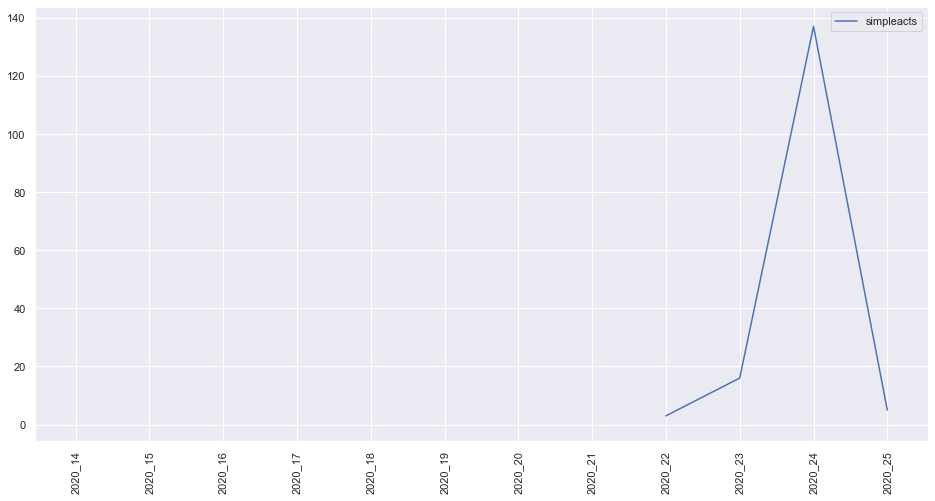

simpleacts 200
refugeeweek2020 119
imagine 61
refugeeweek 34
refugees 12
readabook 10
watchafilm 8
takeatour 7
movingworlds 6
refugee 5
refugeeswelcome 4
exile 4
worldrefugeeday 3
becauseofcld 3
lockdown 2

------------------------------------------



In [177]:
hashtag_check(df_tweets,["simpleacts"],"hashtags")

In [178]:
df_tweets_rday_2 = df_tweets_rday[df_tweets_rday["hashtags"].apply(lambda x: element_in_list(x,rday_hashtags_2))]
df_tweets_rday_2.shape

(27127, 25)

In [179]:
hashtag_count = get_entity_count(df_tweets_rday_2["hashtags"])

# Remove hashtags that are already in list
for hashtag in seen_hashtags:
    hashtag_count.pop(hashtag)

# Sort hashtags by frequency
hashtag_count_sorted = sorted(hashtag_count.items(), key=lambda x: x[1], reverse=True)
hashtag_count_sorted[:25]

[('refugees', 3138),
 ('palestinianrefugees', 2920),
 ('covid19', 1625),
 ('refugee', 931),
 ('refugeeswelcome', 616),
 ('imagine', 561),
 ('unhcr', 348),
 ('fintech', 308),
 ('finclusion', 305),
 ('humanrights', 300),
 ('rohingya', 188),
 ('turkey', 168),
 ('coronavirus', 161),
 ('uganda', 131),
 ('education', 129),
 ('asylumseekers', 128),
 ('syria', 125),
 ('migrants', 125),
 ('peace', 104),
 ('covid', 96),
 ('kenya', 59),
 ('inspector4turkeyunhcr', 59),
 ('sosiranianrefugeesinturkey', 58),
 ('myanmar', 57),
 ('gameover', 57)]

In [180]:
rday_hashtags_3 = rday_hashtags_2 + ["refugeessavelives"]

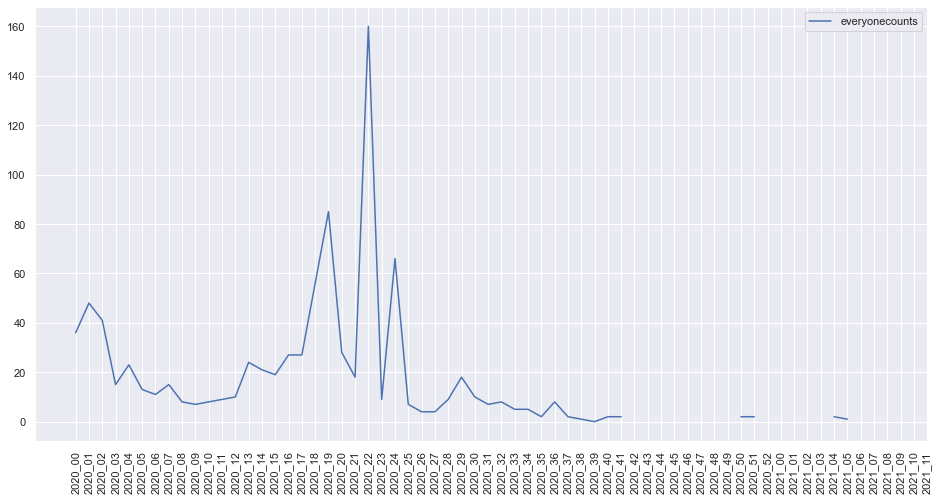

everyonecounts 1210
covid19 147
everyoneequal 134
2020census 133
withrefugees 106
refugees 89
eachonereachone 72
censusday 61
worldrefugeeday 56
coronavirus 35
refugeeforum 29
greece 25
census2020 24
unhcr 22
kos 21

------------------------------------------



In [181]:
hashtag_check(df_tweets,["everyonecounts"],"hashtags")

In [182]:
df_tweets_rday_3 = df_tweets_rday[df_tweets_rday["hashtags"].apply(lambda x: element_in_list(x,rday_hashtags_3))]
df_tweets_rday_3.shape

(27129, 25)

In [183]:
rday_hashtag_qualifier = rday_hashtags_3

#### Create event qualifier

In [184]:
annotation_count = get_entity_count(df_tweets_rday_3["annotations"])

# Sort hashtags by frequency
annotation_count_sorted = sorted(annotation_count.items(), key=lambda x: x[1], reverse=True)
annotation_count_sorted[:25]

[('world refugee day', 1205),
 ('israel', 863),
 ('turkey', 635),
 ('uk', 577),
 ('europe', 512),
 ('palestine', 421),
 ('syria', 321),
 ('canada', 306),
 ('paypal', 305),
 ('unrwa', 277),
 ('refugee week', 271),
 ('lebanon', 222),
 ('uganda', 214),
 ('australia', 205),
 ('us', 195),
 ('jordan', 191),
 ('gaza', 170),
 ('bangladesh', 164),
 ('united nations', 150),
 ('u.s.', 149),
 ('kenya', 148),
 ('gaza strip', 132),
 ('unhcr', 124),
 ('facebook', 120),
 ('israeli', 119)]

In [185]:
rday_annotation_qualifier = ["world refugee day","refugee week"]

In [186]:
mention_count = get_entity_count(df_tweets_rday_3["mentions"])

# Sort hashtags by frequency
mention_count_sorted = sorted(mention_count.items(), key=lambda x: x[1], reverse=True)
mention_count_sorted[:25]

[('refugees', 2123),
 ('refugeeweek', 522),
 ('un', 289),
 ('rescueorg', 197),
 ('unhcrireland', 171),
 ('filippograndi', 168),
 ('freedomunitedhq', 158),
 ('unhcrturkey', 120),
 ('unhcr_kenya', 112),
 ('unhcrcanada', 106),
 ('unhcruk', 83),
 ('unhcruganda', 83),
 ('sanctuaryrunner', 81),
 ('wfp', 68),
 ('globalgiving', 67),
 ('ozrefugeecounc', 64),
 ('antonioguterres', 64),
 ('unicef', 63),
 ('unrefugees', 60),
 ('unhcr', 58),
 ('counterarts', 56),
 ('youtube', 55),
 ('cityofsanctuary', 54),
 ('scotrefcouncil', 54),
 ('gilliantriggs', 53)]

In [187]:
rday_mention_qualifier = []

#### Create event dataset

In [188]:
rday_qualifier = set(rday_hashtag_qualifier + rday_annotation_qualifier)

In [335]:
df_tweets_rday_final = df_tweets_rday[df_tweets_rday["text_clean"].apply(lambda x: element_in_list(x.split(" "),rday_qualifier))]
df_tweets_rday_final = df_tweets_rday_final.append(df_tweets_rday_3).drop_duplicates(subset=["id"])

In [336]:
df_tweets_rday_final.shape

(28079, 25)

#### Visualize event

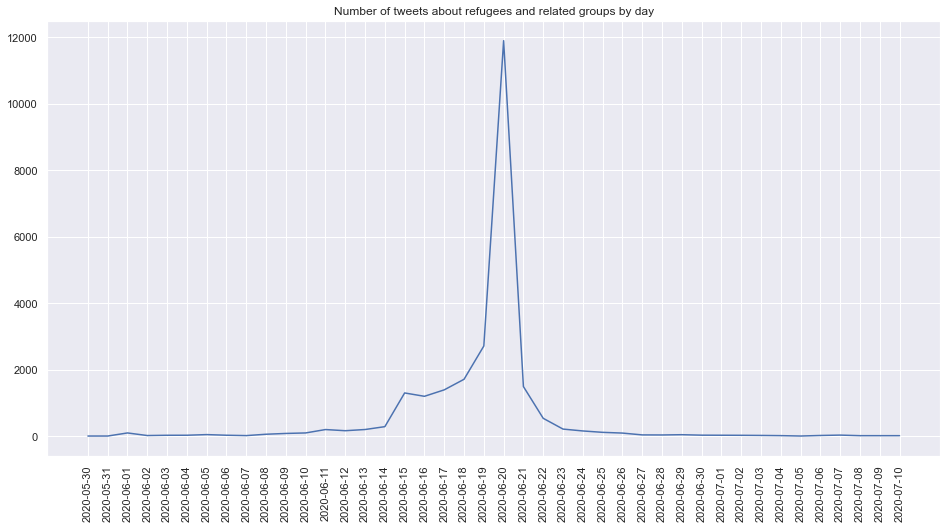

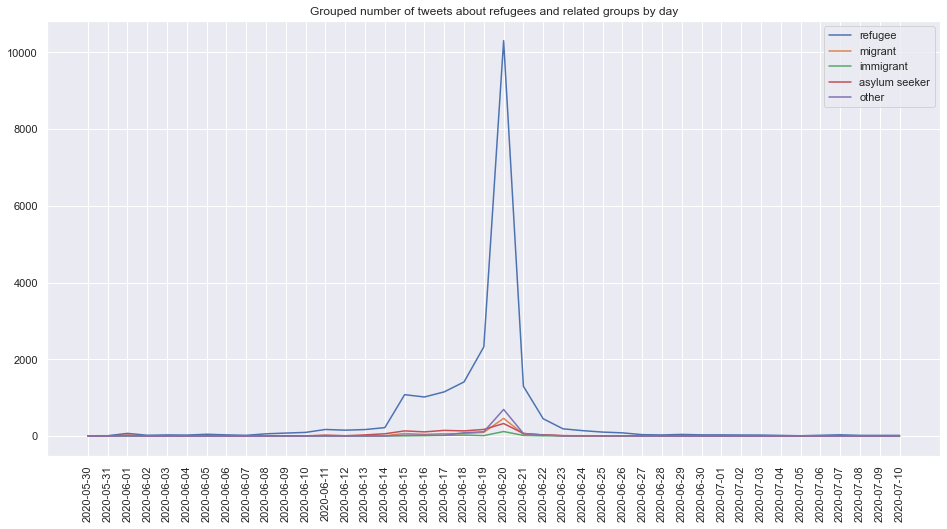

In [337]:
plot_event_timeline(df_tweets_rday_final,"day")

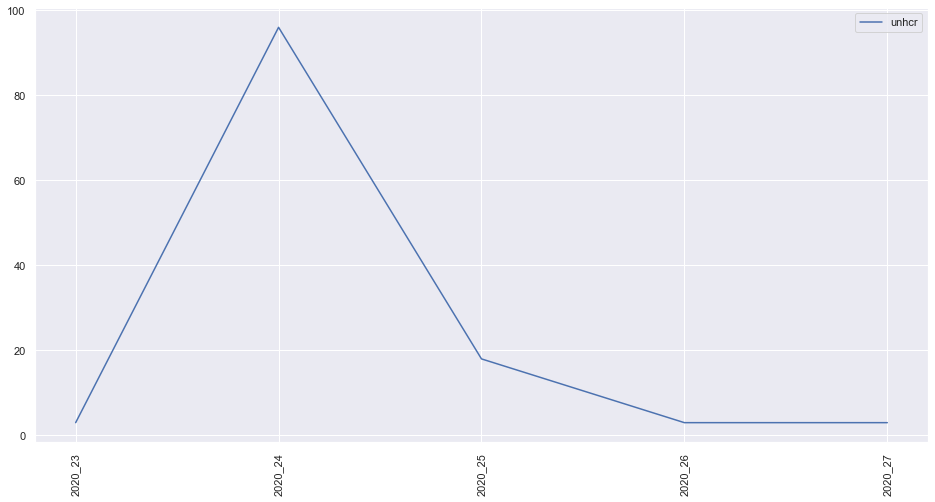

In [338]:
plot_entity_timeline(df_tweets_rday_final, "week", ["unhcr"], "annotations")

In [339]:
df_tweets_rday_final.iloc[2000,1]

'#WorldRefugeeDay is fast approaching &amp; to celebrate, #CanadaHouse &amp; @BerthaDocHouse co-hosting a virtual screening of @InsideMyHeartdf, a moving documentary on the journey of three refugee families seeking protection in Europe. Sign up at ‚û°Ô∏èhttps://t.co/wBz4GQJX6K. üá®üá¶\U0001fac2üåé https://t.co/hvNgbRBOcQ'

#### Export the dataset as csv

In [340]:
rday_path = FILE_PATH + "\Event Dataframes\df_refugeeday.csv"

In [341]:
df_tweets_rday_final.to_csv(rday_path)

---

---
## Overview of events

In [138]:
df_tweets_grouped = group_df(df_tweets,"week")
df_tweets_channel_grouped = group_df(df_tweets_channel,"week")
df_tweets_beirut_grouped = group_df(df_tweets_beirut,"week")
df_tweets_moria_grouped = group_df(df_tweets_moria,"week")
df_tweets_tigray_grouped = group_df(df_tweets_tigray,"week")

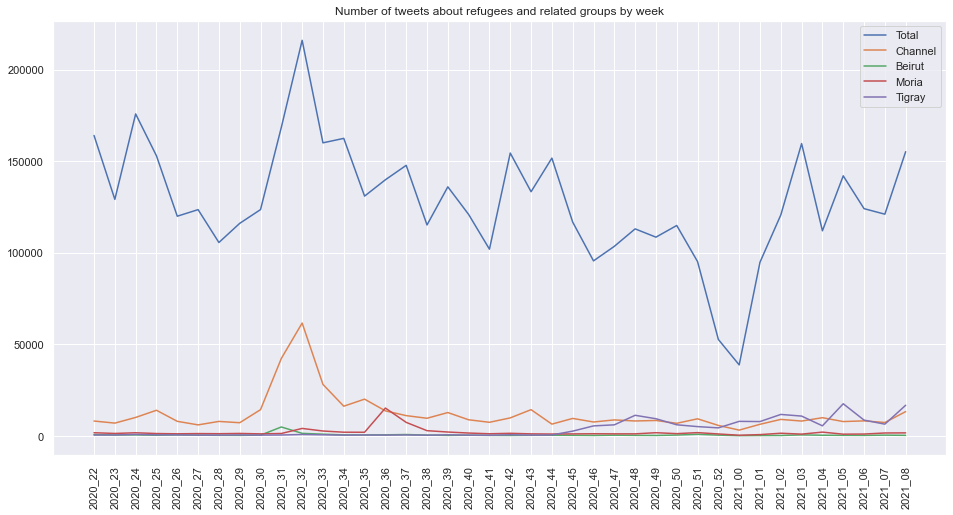

In [139]:
plt.figure(figsize=(16, 8))
plt.plot(df_tweets_grouped["total"], label = "Total")
plt.plot(df_tweets_channel_grouped["total"], label = "Channel")
plt.plot(df_tweets_beirut_grouped["total"], label = "Beirut")
plt.plot(df_tweets_moria_grouped["total"], label = "Moria")
plt.plot(df_tweets_tigray_grouped["total"], label = "Tigray")
plt.title(f"Number of tweets about refugees and related groups by week")
plt.xticks(rotation=90)
plt.legend()
plt.show()